In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.1.4


# Transit fitting

*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

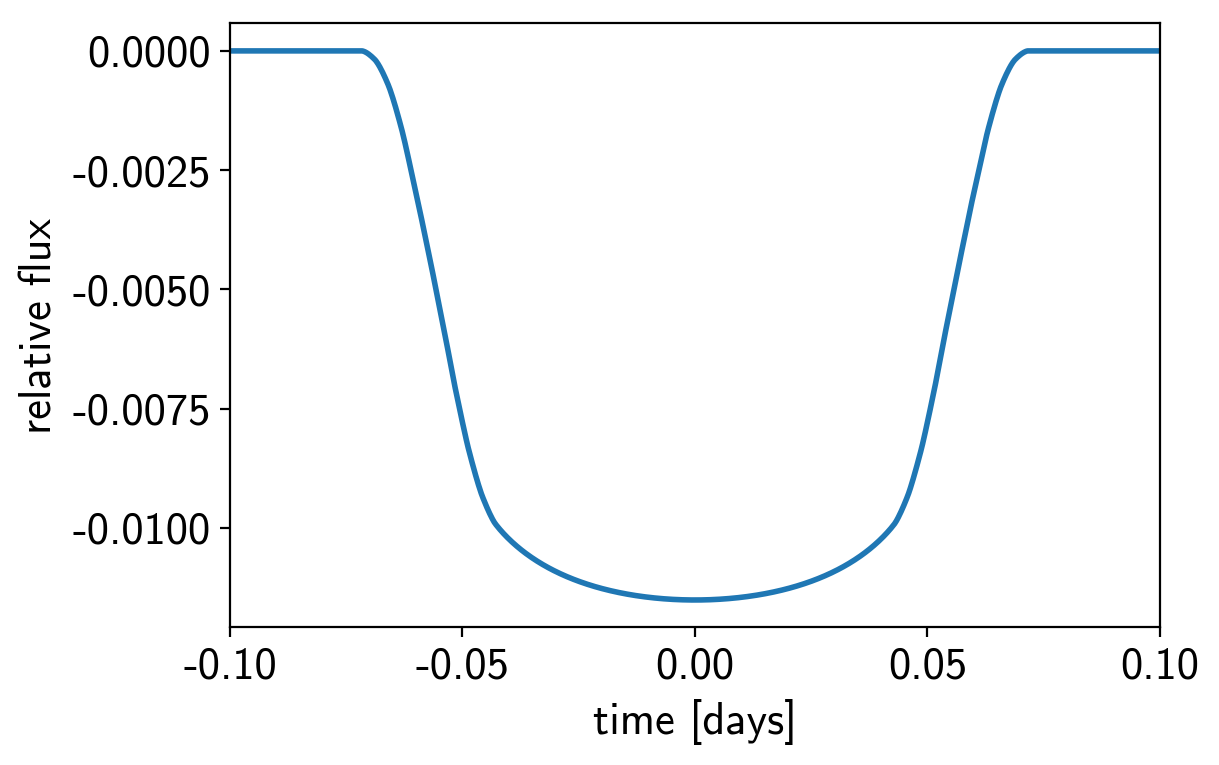

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=3.456)

# Compute a limb-darkened light curve using starry
t = np.linspace(-0.1, 0.1, 1000)
u = [0.3, 0.2]
light_curve = xo.StarryLightCurve(u).get_light_curve(
    orbit=orbit, r=0.1, t=t, texp=0.02).eval()
# Note: the `eval` is needed because this is using Theano in
# the background

plt.plot(t, light_curve, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(t.min(), t.max());

But the real power comes from the fact that this is defined as a [Theano operation](http://deeplearning.net/software/theano/extending/extending_theano.html) so it can be combined with PyMC3 to do transit inference using Hamiltonian Monte Carlo.

## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

In [4]:
np.random.seed(123)
periods = np.random.uniform(5, 20, 2)
t0s = periods * np.random.rand(2)
t = np.arange(0, 80, 0.02)
yerr = 5e-4

Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009) and for the joint radius ratio and impact parameter distribution we'll use the parameterization from [Espinoza (2018)](https://arxiv.org/abs/1811.04859).
Both of these reparameterizations are implemented in *exoplanet* as custom *PyMC3* distributions (:class:`exoplanet.distributions.QuadLimbDark` and :class:`exoplanet.distributions.RadiusImpact` respectively).

In [5]:
import pymc3 as pm

with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)
    
    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=2)
    
    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))
    
    # The Espinoza (2018) parameterization for the joint radius ratio and
    # impact parameter distribution
    r, b = xo.distributions.get_joint_radius_impact(
        min_radius=0.01, max_radius=0.1,
        testval_r=np.array([0.04, 0.06]),
        testval_b=np.random.rand(2)
    )
    
    # This shouldn't make a huge difference, but I like to put a uniform
    # prior on the *log* of the radius ratio instead of the value. This
    # can be implemented by adding a custom "potential" (log probability).
    pm.Potential("r_prior", -pm.math.log(r))
    
    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)
    
    # Compute the model light curve using starry
    light_curves = xo.StarryLightCurve(u).get_light_curve(
        orbit=orbit, r=r, t=t)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    
    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)
    
    # In this line, we simulate the dataset that we will fit
    y = xo.eval_in_model(light_curve)
    y += yerr * np.random.randn(len(y))
    
    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)
    
    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln = xo.optimize(start=model.test_point)

success: False
initial logp: 24793.972586707856
final logp: 24799.526978939903


Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

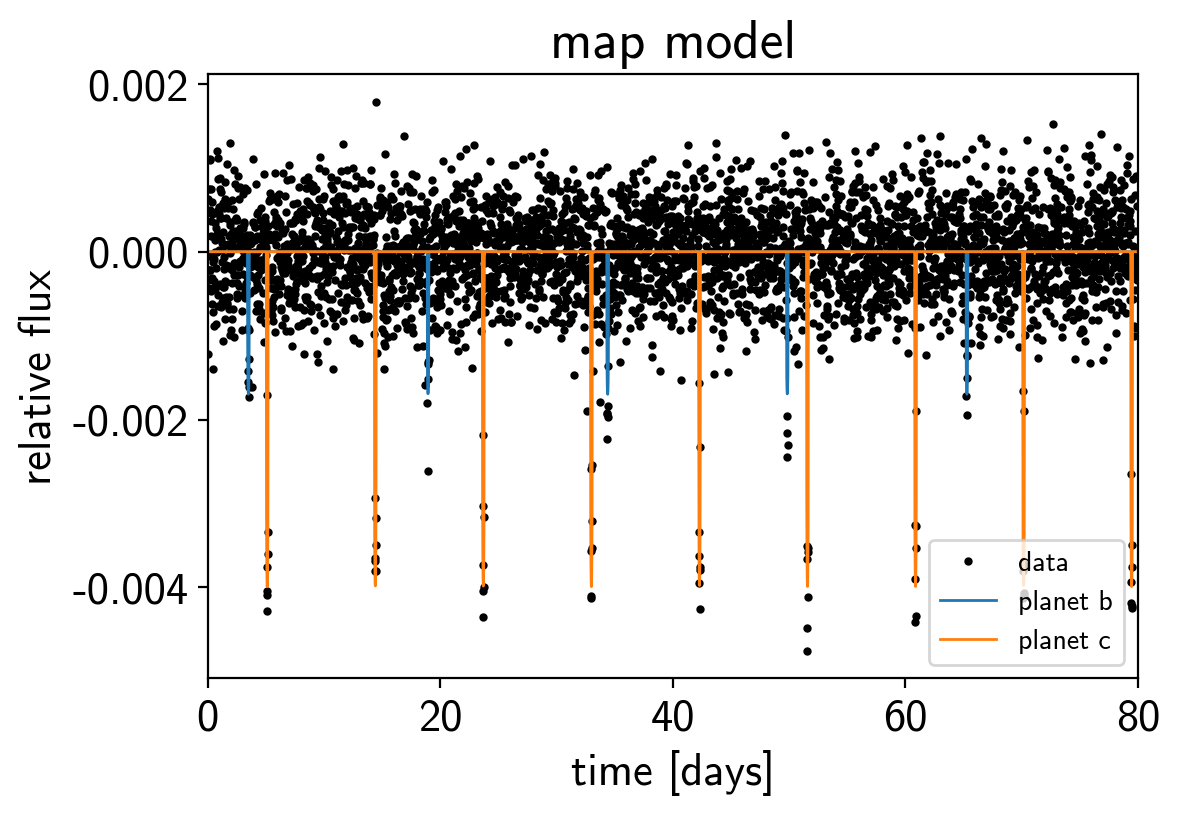

In [6]:
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(t, map_soln["light_curves"][:, i], lw=1,
             label="planet {0}".format(l))
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
plt.title("map model");

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use the :class:`exoplanet.PyMC3Sampler` to sample.

In [7]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(window=100, finish=200)
with model:
    burnin = sampler.tune(tune=2500, start=map_soln, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=3000)

Sampling 4 chains:   0%|          | 0/308 [00:00<?, ?draws/s]

Sampling 4 chains:   7%|▋         | 21/308 [00:00<00:02, 101.67draws/s]

Sampling 4 chains:   8%|▊         | 25/308 [00:00<00:05, 50.13draws/s] 

Sampling 4 chains:   9%|▉         | 29/308 [00:00<00:07, 37.07draws/s]

Sampling 4 chains:  11%|█         | 33/308 [00:00<00:08, 31.34draws/s]

Sampling 4 chains:  12%|█▏        | 37/308 [00:00<00:09, 28.30draws/s]

Sampling 4 chains:  13%|█▎        | 41/308 [00:01<00:10, 26.40draws/s]

Sampling 4 chains:  15%|█▍        | 45/308 [00:01<00:10, 25.33draws/s]

Sampling 4 chains:  16%|█▌        | 49/308 [00:01<00:10, 24.63draws/s]

Sampling 4 chains:  17%|█▋        | 53/308 [00:01<00:10, 24.19draws/s]

Sampling 4 chains:  19%|█▉        | 58/308 [00:01<00:10, 24.85draws/s]

Sampling 4 chains:  20%|██        | 62/308 [00:01<00:10, 23.39draws/s]

Sampling 4 chains:  22%|██▏       | 67/308 [00:02<00:09, 24.42draws/s]

Sampling 4 chains:  23%|██▎       | 71/308 [00:02<00:09, 23.94draws/s]

Sampling 4 chains:  24%|██▍       | 75/308 [00:02<00:09, 23.59draws/s]

Sampling 4 chains:  26%|██▌       | 79/308 [00:02<00:09, 23.16draws/s]

Sampling 4 chains:  27%|██▋       | 83/308 [00:02<00:09, 23.00draws/s]

Sampling 4 chains:  28%|██▊       | 87/308 [00:03<00:09, 22.98draws/s]

Sampling 4 chains:  30%|██▉       | 91/308 [00:03<00:09, 22.98draws/s]

Sampling 4 chains:  31%|███       | 95/308 [00:03<00:09, 22.98draws/s]

Sampling 4 chains:  32%|███▏      | 100/308 [00:03<00:08, 24.45draws/s]

Sampling 4 chains:  34%|███▍      | 104/308 [00:03<00:08, 23.96draws/s]

Sampling 4 chains:  35%|███▌      | 108/308 [00:03<00:08, 23.66draws/s]

Sampling 4 chains:  36%|███▋      | 112/308 [00:04<00:08, 23.09draws/s]

Sampling 4 chains:  38%|███▊      | 116/308 [00:04<00:08, 23.03draws/s]

Sampling 4 chains:  39%|███▉      | 120/308 [00:04<00:08, 23.02draws/s]

Sampling 4 chains:  40%|████      | 124/308 [00:04<00:08, 23.00draws/s]

Sampling 4 chains:  42%|████▏     | 128/308 [00:04<00:07, 22.93draws/s]

Sampling 4 chains:  43%|████▎     | 132/308 [00:04<00:07, 22.85draws/s]

Sampling 4 chains:  44%|████▍     | 136/308 [00:05<00:07, 22.90draws/s]

Sampling 4 chains:  45%|████▌     | 140/308 [00:05<00:07, 22.94draws/s]

Sampling 4 chains:  47%|████▋     | 144/308 [00:05<00:07, 22.97draws/s]

Sampling 4 chains:  48%|████▊     | 149/308 [00:05<00:06, 24.27draws/s]

Sampling 4 chains:  50%|████▉     | 153/308 [00:05<00:06, 23.95draws/s]

Sampling 4 chains:  51%|█████     | 157/308 [00:06<00:06, 23.40draws/s]

Sampling 4 chains:  52%|█████▏    | 161/308 [00:06<00:06, 23.25draws/s]

Sampling 4 chains:  54%|█████▎    | 165/308 [00:06<00:06, 23.23draws/s]

Sampling 4 chains:  55%|█████▍    | 169/308 [00:06<00:05, 23.24draws/s]

Sampling 4 chains:  56%|█████▌    | 173/308 [00:06<00:05, 23.25draws/s]

Sampling 4 chains:  57%|█████▋    | 177/308 [00:06<00:05, 23.26draws/s]

Sampling 4 chains:  59%|█████▉    | 181/308 [00:07<00:05, 23.26draws/s]

Sampling 4 chains:  60%|██████    | 185/308 [00:07<00:05, 23.26draws/s]

Sampling 4 chains:  61%|██████▏   | 189/308 [00:07<00:05, 23.26draws/s]

Sampling 4 chains:  63%|██████▎   | 193/308 [00:07<00:04, 23.26draws/s]

Sampling 4 chains:  64%|██████▍   | 197/308 [00:07<00:04, 23.03draws/s]

Sampling 4 chains:  65%|██████▌   | 201/308 [00:07<00:04, 23.10draws/s]

Sampling 4 chains:  67%|██████▋   | 205/308 [00:08<00:04, 23.07draws/s]

Sampling 4 chains:  68%|██████▊   | 209/308 [00:08<00:04, 23.11draws/s]

Sampling 4 chains:  69%|██████▉   | 213/308 [00:08<00:04, 23.17draws/s]

Sampling 4 chains:  70%|███████   | 217/308 [00:08<00:03, 23.16draws/s]

Sampling 4 chains:  72%|███████▏  | 221/308 [00:08<00:03, 23.20draws/s]

Sampling 4 chains:  73%|███████▎  | 225/308 [00:08<00:03, 23.23draws/s]

Sampling 4 chains:  74%|███████▍  | 229/308 [00:09<00:03, 23.24draws/s]

Sampling 4 chains:  76%|███████▌  | 233/308 [00:09<00:03, 23.19draws/s]

Sampling 4 chains:  77%|███████▋  | 237/308 [00:09<00:03, 23.20draws/s]

Sampling 4 chains:  78%|███████▊  | 241/308 [00:09<00:02, 23.23draws/s]

Sampling 4 chains:  80%|███████▉  | 245/308 [00:09<00:02, 23.24draws/s]

Sampling 4 chains:  81%|████████  | 249/308 [00:09<00:02, 23.26draws/s]

Sampling 4 chains:  82%|████████▏ | 253/308 [00:10<00:02, 23.25draws/s]

Sampling 4 chains:  83%|████████▎ | 257/308 [00:10<00:02, 23.26draws/s]

Sampling 4 chains:  85%|████████▍ | 261/308 [00:10<00:02, 23.26draws/s]

Sampling 4 chains:  86%|████████▌ | 265/308 [00:10<00:01, 23.26draws/s]

Sampling 4 chains:  87%|████████▋ | 269/308 [00:10<00:01, 23.26draws/s]

Sampling 4 chains:  89%|████████▊ | 273/308 [00:11<00:01, 23.26draws/s]

Sampling 4 chains:  90%|████████▉ | 277/308 [00:11<00:01, 23.27draws/s]

Sampling 4 chains:  91%|█████████ | 281/308 [00:11<00:01, 23.27draws/s]

Sampling 4 chains:  92%|█████████▏| 284/308 [00:11<00:00, 24.89draws/s]

Sampling 4 chains:  93%|█████████▎| 287/308 [00:11<00:00, 24.45draws/s]

Sampling 4 chains:  94%|█████████▍| 290/308 [00:11<00:00, 23.92draws/s]

Sampling 4 chains:  95%|█████████▌| 293/308 [00:11<00:00, 21.92draws/s]

Sampling 4 chains:  96%|█████████▌| 296/308 [00:11<00:00, 23.68draws/s]

Sampling 4 chains:  97%|█████████▋| 299/308 [00:12<00:00, 23.85draws/s]

Sampling 4 chains:  98%|█████████▊| 302/308 [00:12<00:00, 21.43draws/s]

Sampling 4 chains:  99%|█████████▉| 305/308 [00:12<00:00, 12.50draws/s]

Sampling 4 chains: 100%|█████████▉| 307/308 [00:12<00:00, 11.16draws/s]

Sampling 4 chains: 100%|██████████| 308/308 [00:13<00:00, 23.28draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:03, 102.60draws/s]

Sampling 4 chains:   6%|▌         | 25/408 [00:00<00:07, 50.27draws/s] 

Sampling 4 chains:   7%|▋         | 29/408 [00:00<00:10, 37.06draws/s]

Sampling 4 chains:   8%|▊         | 34/408 [00:00<00:10, 34.10draws/s]

Sampling 4 chains:   9%|▉         | 38/408 [00:00<00:12, 29.79draws/s]

Sampling 4 chains:  11%|█         | 43/408 [00:01<00:12, 29.36draws/s]

Sampling 4 chains:  12%|█▏        | 47/408 [00:01<00:13, 27.11draws/s]

Sampling 4 chains:  12%|█▎        | 51/408 [00:01<00:13, 25.75draws/s]

Sampling 4 chains:  14%|█▍        | 57/408 [00:01<00:12, 27.87draws/s]

Sampling 4 chains:  15%|█▍        | 61/408 [00:01<00:13, 25.94draws/s]

Sampling 4 chains:  16%|█▌        | 66/408 [00:01<00:12, 26.69draws/s]

Sampling 4 chains:  17%|█▋        | 71/408 [00:02<00:12, 27.24draws/s]

Sampling 4 chains:  19%|█▊        | 76/408 [00:02<00:12, 27.65draws/s]

Sampling 4 chains:  20%|█▉        | 81/408 [00:02<00:10, 31.79draws/s]

Sampling 4 chains:  21%|██        | 85/408 [00:02<00:11, 28.11draws/s]

Sampling 4 chains:  22%|██▏       | 89/408 [00:02<00:12, 26.21draws/s]

Sampling 4 chains:  23%|██▎       | 92/408 [00:02<00:12, 25.68draws/s]

Sampling 4 chains:  24%|██▎       | 96/408 [00:03<00:11, 27.72draws/s]

Sampling 4 chains:  24%|██▍       | 99/408 [00:03<00:11, 25.95draws/s]

Sampling 4 chains:  25%|██▌       | 102/408 [00:03<00:12, 24.35draws/s]

Sampling 4 chains:  26%|██▌       | 105/408 [00:03<00:12, 23.33draws/s]

Sampling 4 chains:  26%|██▋       | 108/408 [00:03<00:12, 24.60draws/s]

Sampling 4 chains:  27%|██▋       | 111/408 [00:03<00:12, 23.44draws/s]

Sampling 4 chains:  28%|██▊       | 114/408 [00:03<00:12, 23.20draws/s]

Sampling 4 chains:  29%|██▊       | 117/408 [00:03<00:13, 21.82draws/s]

Sampling 4 chains:  30%|██▉       | 121/408 [00:04<00:13, 21.94draws/s]

Sampling 4 chains:  31%|███       | 127/408 [00:04<00:11, 24.39draws/s]

Sampling 4 chains:  32%|███▏      | 131/408 [00:04<00:11, 24.01draws/s]

Sampling 4 chains:  33%|███▎      | 136/408 [00:04<00:10, 25.30draws/s]

Sampling 4 chains:  35%|███▍      | 141/408 [00:04<00:10, 26.12draws/s]

Sampling 4 chains:  36%|███▌      | 146/408 [00:05<00:09, 26.68draws/s]

Sampling 4 chains:  37%|███▋      | 150/408 [00:05<00:10, 25.47draws/s]

Sampling 4 chains:  38%|███▊      | 155/408 [00:05<00:09, 26.26draws/s]

Sampling 4 chains:  39%|███▉      | 159/408 [00:05<00:09, 25.19draws/s]

Sampling 4 chains:  40%|███▉      | 163/408 [00:05<00:10, 24.41draws/s]

Sampling 4 chains:  41%|████      | 167/408 [00:05<00:10, 24.00draws/s]

Sampling 4 chains:  42%|████▏     | 171/408 [00:06<00:09, 23.75draws/s]

Sampling 4 chains:  43%|████▎     | 175/408 [00:06<00:09, 23.57draws/s]

Sampling 4 chains:  44%|████▍     | 179/408 [00:06<00:09, 23.34draws/s]

Sampling 4 chains:  45%|████▌     | 184/408 [00:06<00:09, 24.59draws/s]

Sampling 4 chains:  46%|████▌     | 188/408 [00:06<00:09, 24.09draws/s]

Sampling 4 chains:  47%|████▋     | 192/408 [00:06<00:09, 23.79draws/s]

Sampling 4 chains:  48%|████▊     | 197/408 [00:07<00:07, 28.14draws/s]

Sampling 4 chains:  49%|████▉     | 201/408 [00:07<00:07, 26.30draws/s]

Sampling 4 chains:  50%|█████     | 204/408 [00:07<00:08, 24.14draws/s]

Sampling 4 chains:  51%|█████     | 207/408 [00:07<00:07, 25.43draws/s]

Sampling 4 chains:  51%|█████▏    | 210/408 [00:07<00:07, 26.19draws/s]

Sampling 4 chains:  52%|█████▏    | 213/408 [00:07<00:08, 24.24draws/s]

Sampling 4 chains:  53%|█████▎    | 216/408 [00:07<00:08, 21.63draws/s]

Sampling 4 chains:  54%|█████▍    | 220/408 [00:08<00:08, 22.06draws/s]

Sampling 4 chains:  55%|█████▍    | 224/408 [00:08<00:08, 22.37draws/s]

Sampling 4 chains:  56%|█████▌    | 229/408 [00:08<00:07, 24.01draws/s]

Sampling 4 chains:  57%|█████▋    | 233/408 [00:08<00:07, 23.68draws/s]

Sampling 4 chains:  58%|█████▊    | 237/408 [00:08<00:07, 23.52draws/s]

Sampling 4 chains:  59%|█████▉    | 241/408 [00:08<00:07, 23.40draws/s]

Sampling 4 chains:  60%|██████    | 245/408 [00:09<00:06, 23.32draws/s]

Sampling 4 chains:  61%|██████▏   | 250/408 [00:09<00:06, 24.75draws/s]

Sampling 4 chains:  62%|██████▏   | 254/408 [00:09<00:06, 24.23draws/s]

Sampling 4 chains:  63%|██████▎   | 258/408 [00:09<00:06, 23.89draws/s]

Sampling 4 chains:  64%|██████▍   | 262/408 [00:09<00:06, 23.66draws/s]

Sampling 4 chains:  65%|██████▌   | 267/408 [00:09<00:05, 24.81draws/s]

Sampling 4 chains:  67%|██████▋   | 272/408 [00:10<00:05, 25.41draws/s]

Sampling 4 chains:  68%|██████▊   | 276/408 [00:10<00:05, 24.66draws/s]

Sampling 4 chains:  69%|██████▊   | 280/408 [00:10<00:05, 24.16draws/s]

Sampling 4 chains:  70%|██████▉   | 284/408 [00:10<00:05, 23.82draws/s]

Sampling 4 chains:  71%|███████   | 288/408 [00:10<00:05, 23.60draws/s]

Sampling 4 chains:  72%|███████▏  | 295/408 [00:11<00:04, 26.79draws/s]

Sampling 4 chains:  73%|███████▎  | 299/408 [00:11<00:04, 25.58draws/s]

Sampling 4 chains:  75%|███████▍  | 304/408 [00:11<00:03, 26.49draws/s]

Sampling 4 chains:  75%|███████▌  | 308/408 [00:11<00:03, 25.38draws/s]

Sampling 4 chains:  77%|███████▋  | 313/408 [00:11<00:03, 26.16draws/s]

Sampling 4 chains:  78%|███████▊  | 317/408 [00:11<00:03, 25.16draws/s]

Sampling 4 chains:  78%|███████▊  | 320/408 [00:11<00:03, 26.43draws/s]

Sampling 4 chains:  79%|███████▉  | 323/408 [00:12<00:03, 25.33draws/s]

Sampling 4 chains:  80%|███████▉  | 326/408 [00:12<00:03, 22.30draws/s]

Sampling 4 chains:  81%|████████  | 329/408 [00:12<00:03, 23.12draws/s]

Sampling 4 chains:  81%|████████▏ | 332/408 [00:12<00:03, 24.47draws/s]

Sampling 4 chains:  82%|████████▏ | 335/408 [00:12<00:03, 23.84draws/s]

Sampling 4 chains:  83%|████████▎ | 338/408 [00:12<00:02, 24.96draws/s]

Sampling 4 chains:  84%|████████▎ | 341/408 [00:12<00:02, 25.59draws/s]

Sampling 4 chains:  84%|████████▍ | 344/408 [00:13<00:02, 24.09draws/s]

Sampling 4 chains:  85%|████████▌ | 347/408 [00:13<00:02, 22.69draws/s]

Sampling 4 chains:  86%|████████▌ | 350/408 [00:13<00:02, 23.50draws/s]

Sampling 4 chains:  87%|████████▋ | 354/408 [00:13<00:02, 25.83draws/s]

Sampling 4 chains:  88%|████████▊ | 357/408 [00:13<00:02, 24.25draws/s]

Sampling 4 chains:  88%|████████▊ | 361/408 [00:13<00:01, 25.29draws/s]

Sampling 4 chains:  89%|████████▉ | 364/408 [00:13<00:01, 25.46draws/s]

Sampling 4 chains:  90%|████████▉ | 367/408 [00:13<00:01, 24.95draws/s]

Sampling 4 chains:  91%|█████████ | 370/408 [00:14<00:01, 22.95draws/s]

Sampling 4 chains:  91%|█████████▏| 373/408 [00:14<00:01, 23.59draws/s]

Sampling 4 chains:  92%|█████████▏| 376/408 [00:14<00:01, 24.05draws/s]

Sampling 4 chains:  93%|█████████▎| 379/408 [00:14<00:01, 24.71draws/s]

Sampling 4 chains:  94%|█████████▎| 382/408 [00:14<00:01, 24.99draws/s]

Sampling 4 chains:  94%|█████████▍| 385/408 [00:14<00:00, 25.27draws/s]

Sampling 4 chains:  95%|█████████▌| 388/408 [00:14<00:00, 24.13draws/s]

Sampling 4 chains:  96%|█████████▌| 391/408 [00:14<00:00, 23.31draws/s]

Sampling 4 chains:  97%|█████████▋| 395/408 [00:15<00:00, 22.33draws/s]

Sampling 4 chains:  98%|█████████▊| 398/408 [00:15<00:00, 20.45draws/s]

Sampling 4 chains:  98%|█████████▊| 401/408 [00:15<00:00, 15.11draws/s]

Sampling 4 chains:  99%|█████████▉| 403/408 [00:15<00:00, 12.48draws/s]

Sampling 4 chains:  99%|█████████▉| 405/408 [00:16<00:00, 12.46draws/s]

Sampling 4 chains: 100%|█████████▉| 407/408 [00:16<00:00, 11.42draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:16<00:00, 24.09draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/808 [00:00<01:32,  8.77draws/s]

Sampling 4 chains:   1%|          | 7/808 [00:00<01:08, 11.73draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:00<00:53, 14.85draws/s]

Sampling 4 chains:   2%|▏         | 18/808 [00:00<00:42, 18.74draws/s]

Sampling 4 chains:   3%|▎         | 23/808 [00:00<00:34, 22.68draws/s]

Sampling 4 chains:   3%|▎         | 27/808 [00:00<00:34, 22.63draws/s]

Sampling 4 chains:   4%|▍         | 31/808 [00:00<00:34, 22.62draws/s]

Sampling 4 chains:   4%|▍         | 34/808 [00:01<00:35, 22.03draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:01<00:34, 22.35draws/s]

Sampling 4 chains:   5%|▌         | 42/808 [00:01<00:34, 22.36draws/s]

Sampling 4 chains:   6%|▌         | 46/808 [00:01<00:34, 22.33draws/s]

Sampling 4 chains:   6%|▌         | 50/808 [00:01<00:33, 22.38draws/s]

Sampling 4 chains:   7%|▋         | 54/808 [00:01<00:29, 25.42draws/s]

Sampling 4 chains:   7%|▋         | 58/808 [00:02<00:26, 28.50draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:02<00:28, 26.26draws/s]

Sampling 4 chains:   8%|▊         | 67/808 [00:02<00:25, 29.30draws/s]

Sampling 4 chains:   9%|▉         | 71/808 [00:02<00:27, 26.90draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:02<00:28, 25.92draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:02<00:30, 23.92draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:02<00:27, 26.63draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:03<00:29, 24.80draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:03<00:27, 26.37draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:03<00:25, 27.58draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:03<00:22, 31.20draws/s]

Sampling 4 chains:  13%|█▎        | 103/808 [00:03<00:19, 36.20draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:03<00:21, 33.12draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:03<00:21, 32.89draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:03<00:22, 31.08draws/s]

Sampling 4 chains:  15%|█▍        | 120/808 [00:04<00:24, 27.80draws/s]

Sampling 4 chains:  15%|█▌        | 123/808 [00:04<00:25, 26.53draws/s]

Sampling 4 chains:  16%|█▌        | 127/808 [00:04<00:25, 26.81draws/s]

Sampling 4 chains:  16%|█▌        | 131/808 [00:04<00:22, 29.66draws/s]

Sampling 4 chains:  17%|█▋        | 135/808 [00:04<00:25, 26.91draws/s]

Sampling 4 chains:  17%|█▋        | 138/808 [00:04<00:24, 27.35draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:04<00:21, 30.76draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:05<00:20, 31.78draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:05<00:20, 32.76draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:05<00:19, 33.77draws/s]

Sampling 4 chains:  20%|██        | 163/808 [00:05<00:16, 39.69draws/s]

Sampling 4 chains:  21%|██        | 168/808 [00:05<00:20, 31.51draws/s]

Sampling 4 chains:  21%|██▏       | 172/808 [00:05<00:20, 31.04draws/s]

Sampling 4 chains:  22%|██▏       | 176/808 [00:05<00:19, 32.93draws/s]

Sampling 4 chains:  22%|██▏       | 180/808 [00:05<00:18, 34.30draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [00:06<00:16, 37.84draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [00:06<00:16, 37.98draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [00:06<00:15, 40.82draws/s]

Sampling 4 chains:  25%|██▍       | 200/808 [00:06<00:14, 41.89draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:06<00:17, 33.87draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [00:06<00:18, 31.90draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:06<00:17, 33.87draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [00:06<00:16, 35.09draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [00:07<00:19, 29.78draws/s]

Sampling 4 chains:  28%|██▊       | 226/808 [00:07<00:21, 27.15draws/s]

Sampling 4 chains:  28%|██▊       | 229/808 [00:07<00:23, 24.39draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [00:07<00:18, 30.62draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [00:07<00:19, 28.99draws/s]

Sampling 4 chains:  30%|███       | 246/808 [00:07<00:20, 27.66draws/s]

Sampling 4 chains:  31%|███       | 250/808 [00:08<00:20, 27.18draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [00:08<00:20, 26.60draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [00:08<00:19, 27.82draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [00:08<00:18, 30.00draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [00:08<00:15, 34.08draws/s]

Sampling 4 chains:  34%|███▎      | 272/808 [00:08<00:18, 29.45draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [00:08<00:20, 26.55draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [00:09<00:20, 26.09draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [00:09<00:16, 31.60draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [00:09<00:16, 31.15draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [00:09<00:16, 31.92draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [00:09<00:14, 34.83draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [00:09<00:15, 33.56draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [00:09<00:16, 30.97draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [00:10<00:15, 31.68draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [00:10<00:17, 28.17draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [00:10<00:15, 30.73draws/s]

Sampling 4 chains:  40%|████      | 326/808 [00:10<00:16, 30.07draws/s]

Sampling 4 chains:  41%|████      | 330/808 [00:10<00:17, 27.29draws/s]

Sampling 4 chains:  41%|████      | 333/808 [00:10<00:17, 26.65draws/s]

Sampling 4 chains:  42%|████▏     | 337/808 [00:10<00:18, 25.27draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [00:11<00:17, 27.27draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [00:11<00:14, 31.78draws/s]

Sampling 4 chains:  44%|████▎     | 352/808 [00:11<00:13, 33.00draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [00:11<00:15, 29.02draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [00:11<00:16, 26.78draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [00:11<00:16, 26.95draws/s]

Sampling 4 chains:  46%|████▌     | 368/808 [00:11<00:14, 29.93draws/s]

Sampling 4 chains:  46%|████▌     | 372/808 [00:12<00:15, 27.34draws/s]

Sampling 4 chains:  47%|████▋     | 376/808 [00:12<00:14, 29.34draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [00:12<00:15, 28.39draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [00:12<00:12, 33.45draws/s]

Sampling 4 chains:  48%|████▊     | 390/808 [00:12<00:13, 31.75draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [00:12<00:14, 29.56draws/s]

Sampling 4 chains:  49%|████▉     | 398/808 [00:12<00:15, 26.87draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [00:13<00:14, 28.27draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [00:13<00:14, 26.97draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [00:13<00:12, 30.60draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [00:13<00:14, 27.55draws/s]

Sampling 4 chains:  52%|█████▏    | 419/808 [00:13<00:14, 27.55draws/s]

Sampling 4 chains:  52%|█████▏    | 422/808 [00:13<00:15, 24.41draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [00:13<00:14, 25.79draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [00:14<00:13, 27.72draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [00:14<00:13, 27.66draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [00:14<00:13, 26.50draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [00:14<00:13, 26.44draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [00:14<00:14, 25.13draws/s]

Sampling 4 chains:  55%|█████▌    | 448/808 [00:14<00:14, 24.30draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [00:14<00:14, 24.73draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [00:15<00:14, 24.81draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [00:15<00:11, 29.18draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [00:15<00:12, 26.81draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [00:15<00:12, 27.70draws/s]

Sampling 4 chains:  59%|█████▉    | 476/808 [00:15<00:10, 32.65draws/s]

Sampling 4 chains:  59%|█████▉    | 480/808 [00:15<00:11, 28.64draws/s]

Sampling 4 chains:  60%|█████▉    | 484/808 [00:15<00:10, 30.41draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [00:16<00:08, 36.45draws/s]

Sampling 4 chains:  61%|██████▏   | 496/808 [00:16<00:10, 30.40draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [00:16<00:11, 27.61draws/s]

Sampling 4 chains:  62%|██████▏   | 504/808 [00:16<00:10, 29.64draws/s]

Sampling 4 chains:  63%|██████▎   | 508/808 [00:16<00:09, 31.27draws/s]

Sampling 4 chains:  63%|██████▎   | 512/808 [00:16<00:10, 28.86draws/s]

Sampling 4 chains:  64%|██████▍   | 516/808 [00:17<00:10, 28.32draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [00:17<00:09, 30.13draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [00:17<00:09, 28.43draws/s]

Sampling 4 chains:  66%|██████▌   | 530/808 [00:17<00:08, 31.23draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [00:17<00:07, 36.05draws/s]

Sampling 4 chains:  67%|██████▋   | 540/808 [00:17<00:07, 36.98draws/s]

Sampling 4 chains:  67%|██████▋   | 545/808 [00:17<00:07, 36.13draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [00:17<00:06, 37.09draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [00:18<00:07, 34.65draws/s]

Sampling 4 chains:  69%|██████▉   | 557/808 [00:18<00:08, 29.77draws/s]

Sampling 4 chains:  69%|██████▉   | 561/808 [00:18<00:08, 29.51draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [00:18<00:07, 31.34draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [00:18<00:07, 31.38draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [00:18<00:07, 31.33draws/s]

Sampling 4 chains:  72%|███████▏  | 578/808 [00:18<00:06, 34.22draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [00:18<00:05, 38.85draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [00:19<00:05, 37.53draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [00:19<00:05, 41.15draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [00:19<00:05, 37.66draws/s]

Sampling 4 chains:  75%|███████▍  | 605/808 [00:19<00:05, 35.29draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [00:19<00:05, 36.44draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [00:19<00:05, 34.32draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [00:19<00:05, 33.52draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [00:20<00:05, 35.11draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [00:20<00:06, 29.96draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [00:20<00:05, 30.46draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [00:20<00:05, 29.72draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [00:20<00:06, 27.02draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [00:20<00:06, 25.28draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [00:20<00:06, 23.91draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [00:21<00:06, 25.97draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [00:21<00:05, 28.00draws/s]

Sampling 4 chains:  81%|████████  | 656/808 [00:21<00:05, 26.11draws/s]

Sampling 4 chains:  82%|████████▏ | 661/808 [00:21<00:04, 30.29draws/s]

Sampling 4 chains:  82%|████████▏ | 665/808 [00:21<00:04, 29.56draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [00:21<00:05, 27.03draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [00:21<00:05, 26.39draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [00:22<00:04, 29.39draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [00:22<00:03, 31.10draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [00:22<00:04, 27.84draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [00:22<00:03, 31.33draws/s]

Sampling 4 chains:  86%|████████▋ | 697/808 [00:22<00:03, 29.41draws/s]

Sampling 4 chains:  87%|████████▋ | 701/808 [00:22<00:03, 28.07draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [00:22<00:03, 27.75draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [00:23<00:03, 27.39draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [00:23<00:03, 29.40draws/s]

Sampling 4 chains:  88%|████████▊ | 715/808 [00:23<00:03, 26.81draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [00:23<00:03, 28.20draws/s]

Sampling 4 chains:  90%|████████▉ | 726/808 [00:23<00:02, 28.21draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [00:23<00:02, 29.31draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [00:23<00:02, 28.86draws/s]

Sampling 4 chains:  91%|█████████▏| 738/808 [00:24<00:02, 31.15draws/s]

Sampling 4 chains:  92%|█████████▏| 742/808 [00:24<00:02, 27.89draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [00:24<00:02, 26.63draws/s]

Sampling 4 chains:  93%|█████████▎| 750/808 [00:24<00:02, 28.85draws/s]

Sampling 4 chains:  93%|█████████▎| 754/808 [00:24<00:02, 26.53draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [00:24<00:01, 27.30draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [00:24<00:01, 25.52draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [00:25<00:01, 26.22draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [00:25<00:01, 22.28draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [00:25<00:01, 22.31draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [00:25<00:01, 24.43draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [00:25<00:01, 25.24draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [00:25<00:00, 24.92draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [00:26<00:00, 21.73draws/s]

Sampling 4 chains:  98%|█████████▊| 790/808 [00:26<00:00, 20.80draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [00:26<00:00, 21.19draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [00:26<00:00, 20.01draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [00:26<00:00, 18.42draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [00:26<00:00, 17.93draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [00:27<00:00, 15.79draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [00:27<00:00,  9.88draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:27<00:00, 29.00draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|▏         | 23/1608 [00:00<00:07, 225.82draws/s]

Sampling 4 chains:   4%|▎         | 59/1608 [00:00<00:06, 254.23draws/s]

Sampling 4 chains:   6%|▌         | 90/1608 [00:00<00:05, 267.84draws/s]

Sampling 4 chains:   8%|▊         | 128/1608 [00:00<00:05, 292.67draws/s]

Sampling 4 chains:  10%|█         | 162/1608 [00:00<00:04, 304.95draws/s]

Sampling 4 chains:  12%|█▏        | 192/1608 [00:00<00:04, 303.20draws/s]

Sampling 4 chains:  15%|█▍        | 234/1608 [00:00<00:04, 325.79draws/s]

Sampling 4 chains:  17%|█▋        | 272/1608 [00:00<00:03, 338.92draws/s]

Sampling 4 chains:  19%|█▉        | 310/1608 [00:00<00:03, 346.44draws/s]

Sampling 4 chains:  21%|██▏       | 345/1608 [00:01<00:03, 342.95draws/s]

Sampling 4 chains:  24%|██▍       | 385/1608 [00:01<00:03, 353.35draws/s]

Sampling 4 chains:  27%|██▋       | 428/1608 [00:01<00:03, 365.62draws/s]

Sampling 4 chains:  29%|██▉       | 465/1608 [00:01<00:03, 363.29draws/s]

Sampling 4 chains:  32%|███▏      | 508/1608 [00:01<00:02, 377.81draws/s]

Sampling 4 chains:  34%|███▍      | 546/1608 [00:01<00:02, 367.31draws/s]

Sampling 4 chains:  36%|███▋      | 586/1608 [00:01<00:02, 374.84draws/s]

Sampling 4 chains:  39%|███▉      | 624/1608 [00:01<00:02, 369.06draws/s]

Sampling 4 chains:  41%|████      | 662/1608 [00:01<00:02, 366.40draws/s]

Sampling 4 chains:  44%|████▎     | 701/1608 [00:01<00:02, 370.68draws/s]

Sampling 4 chains:  46%|████▌     | 741/1608 [00:02<00:02, 377.64draws/s]

Sampling 4 chains:  48%|████▊     | 779/1608 [00:02<00:02, 378.22draws/s]

Sampling 4 chains:  51%|█████     | 817/1608 [00:02<00:02, 365.22draws/s]

Sampling 4 chains:  53%|█████▎    | 860/1608 [00:02<00:01, 382.06draws/s]

Sampling 4 chains:  56%|█████▌    | 901/1608 [00:02<00:01, 389.92draws/s]

Sampling 4 chains:  59%|█████▊    | 941/1608 [00:02<00:01, 388.30draws/s]

Sampling 4 chains:  61%|██████    | 981/1608 [00:02<00:01, 390.11draws/s]

Sampling 4 chains:  63%|██████▎   | 1021/1608 [00:02<00:01, 370.87draws/s]

Sampling 4 chains:  66%|██████▌   | 1059/1608 [00:02<00:01, 367.49draws/s]

Sampling 4 chains:  69%|██████▊   | 1103/1608 [00:03<00:01, 384.14draws/s]

Sampling 4 chains:  71%|███████   | 1142/1608 [00:03<00:01, 384.16draws/s]

Sampling 4 chains:  73%|███████▎  | 1181/1608 [00:03<00:01, 381.45draws/s]

Sampling 4 chains:  76%|███████▌  | 1220/1608 [00:03<00:01, 376.62draws/s]

Sampling 4 chains:  79%|███████▊  | 1263/1608 [00:03<00:00, 389.53draws/s]

Sampling 4 chains:  81%|████████  | 1303/1608 [00:03<00:00, 391.27draws/s]

Sampling 4 chains:  84%|████████▎ | 1343/1608 [00:03<00:00, 390.37draws/s]

Sampling 4 chains:  86%|████████▌ | 1383/1608 [00:03<00:00, 391.27draws/s]

Sampling 4 chains:  88%|████████▊ | 1423/1608 [00:03<00:00, 378.16draws/s]

Sampling 4 chains:  91%|█████████ | 1462/1608 [00:03<00:00, 380.17draws/s]

Sampling 4 chains:  93%|█████████▎| 1501/1608 [00:04<00:00, 379.05draws/s]

Sampling 4 chains:  96%|█████████▌| 1539/1608 [00:04<00:00, 376.06draws/s]

Sampling 4 chains:  98%|█████████▊| 1577/1608 [00:04<00:00, 342.26draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:04<00:00, 348.63draws/s]

Sampling 4 chains:   0%|          | 0/6908 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 19/6908 [00:00<00:37, 184.60draws/s]

Sampling 4 chains:   1%|          | 44/6908 [00:00<00:34, 199.56draws/s]

Sampling 4 chains:   1%|          | 71/6908 [00:00<00:31, 215.83draws/s]

Sampling 4 chains:   1%|▏         | 101/6908 [00:00<00:28, 235.51draws/s]

Sampling 4 chains:   2%|▏         | 133/6908 [00:00<00:26, 254.82draws/s]

Sampling 4 chains:   2%|▏         | 157/6908 [00:00<00:28, 239.05draws/s]

Sampling 4 chains:   3%|▎         | 183/6908 [00:00<00:27, 243.21draws/s]

Sampling 4 chains:   3%|▎         | 207/6908 [00:00<00:27, 240.54draws/s]

Sampling 4 chains:   4%|▎         | 243/6908 [00:00<00:25, 264.61draws/s]

Sampling 4 chains:   4%|▍         | 270/6908 [00:01<00:25, 260.77draws/s]

Sampling 4 chains:   4%|▍         | 297/6908 [00:01<00:25, 260.35draws/s]

Sampling 4 chains:   5%|▍         | 326/6908 [00:01<00:24, 267.53draws/s]

Sampling 4 chains:   5%|▌         | 359/6908 [00:01<00:23, 282.48draws/s]

Sampling 4 chains:   6%|▌         | 390/6908 [00:01<00:22, 289.97draws/s]

Sampling 4 chains:   6%|▌         | 422/6908 [00:01<00:21, 295.98draws/s]

Sampling 4 chains:   7%|▋         | 452/6908 [00:01<00:22, 291.57draws/s]

Sampling 4 chains:   7%|▋         | 482/6908 [00:01<00:22, 292.00draws/s]

Sampling 4 chains:   7%|▋         | 516/6908 [00:01<00:21, 304.17draws/s]

Sampling 4 chains:   8%|▊         | 547/6908 [00:01<00:20, 304.02draws/s]

Sampling 4 chains:   8%|▊         | 583/6908 [00:02<00:19, 318.25draws/s]

Sampling 4 chains:   9%|▉         | 619/6908 [00:02<00:19, 328.58draws/s]

Sampling 4 chains:   9%|▉         | 653/6908 [00:02<00:19, 317.05draws/s]

Sampling 4 chains:  10%|▉         | 687/6908 [00:02<00:19, 322.08draws/s]

Sampling 4 chains:  10%|█         | 720/6908 [00:02<00:19, 315.47draws/s]

Sampling 4 chains:  11%|█         | 759/6908 [00:02<00:18, 332.03draws/s]

Sampling 4 chains:  11%|█▏        | 793/6908 [00:02<00:18, 331.28draws/s]

Sampling 4 chains:  12%|█▏        | 831/6908 [00:02<00:17, 343.62draws/s]

Sampling 4 chains:  13%|█▎        | 868/6908 [00:02<00:17, 348.54draws/s]

Sampling 4 chains:  13%|█▎        | 906/6908 [00:03<00:16, 357.37draws/s]

Sampling 4 chains:  14%|█▎        | 942/6908 [00:03<00:16, 352.60draws/s]

Sampling 4 chains:  14%|█▍        | 980/6908 [00:03<00:16, 360.19draws/s]

Sampling 4 chains:  15%|█▍        | 1017/6908 [00:03<00:16, 354.62draws/s]

Sampling 4 chains:  15%|█▌        | 1054/6908 [00:03<00:16, 358.45draws/s]

Sampling 4 chains:  16%|█▌        | 1090/6908 [00:03<00:17, 341.87draws/s]

Sampling 4 chains:  16%|█▋        | 1132/6908 [00:03<00:16, 358.94draws/s]

Sampling 4 chains:  17%|█▋        | 1169/6908 [00:03<00:15, 359.70draws/s]

Sampling 4 chains:  18%|█▊        | 1210/6908 [00:03<00:15, 372.57draws/s]

Sampling 4 chains:  18%|█▊        | 1248/6908 [00:03<00:15, 367.64draws/s]

Sampling 4 chains:  19%|█▊        | 1285/6908 [00:04<00:15, 361.94draws/s]

Sampling 4 chains:  19%|█▉        | 1322/6908 [00:04<00:16, 347.23draws/s]

Sampling 4 chains:  20%|█▉        | 1357/6908 [00:04<00:16, 346.23draws/s]

Sampling 4 chains:  20%|██        | 1392/6908 [00:04<00:16, 333.04draws/s]

Sampling 4 chains:  21%|██        | 1426/6908 [00:04<00:16, 332.75draws/s]

Sampling 4 chains:  21%|██        | 1460/6908 [00:04<00:16, 332.21draws/s]

Sampling 4 chains:  22%|██▏       | 1494/6908 [00:04<00:16, 330.85draws/s]

Sampling 4 chains:  22%|██▏       | 1528/6908 [00:04<00:16, 332.13draws/s]

Sampling 4 chains:  23%|██▎       | 1562/6908 [00:04<00:16, 321.36draws/s]

Sampling 4 chains:  23%|██▎       | 1595/6908 [00:05<00:16, 319.51draws/s]

Sampling 4 chains:  24%|██▎       | 1632/6908 [00:05<00:15, 332.65draws/s]

Sampling 4 chains:  24%|██▍       | 1671/6908 [00:05<00:15, 343.04draws/s]

Sampling 4 chains:  25%|██▍       | 1708/6908 [00:05<00:14, 348.49draws/s]

Sampling 4 chains:  25%|██▌       | 1744/6908 [00:05<00:14, 349.16draws/s]

Sampling 4 chains:  26%|██▌       | 1783/6908 [00:05<00:14, 353.73draws/s]

Sampling 4 chains:  26%|██▋       | 1819/6908 [00:05<00:14, 343.91draws/s]

Sampling 4 chains:  27%|██▋       | 1855/6908 [00:05<00:14, 345.91draws/s]

Sampling 4 chains:  27%|██▋       | 1892/6908 [00:05<00:14, 351.55draws/s]

Sampling 4 chains:  28%|██▊       | 1932/6908 [00:05<00:13, 363.29draws/s]

Sampling 4 chains:  29%|██▊       | 1969/6908 [00:06<00:13, 355.82draws/s]

Sampling 4 chains:  29%|██▉       | 2005/6908 [00:06<00:14, 339.08draws/s]

Sampling 4 chains:  30%|██▉       | 2044/6908 [00:06<00:13, 349.34draws/s]

Sampling 4 chains:  30%|███       | 2081/6908 [00:06<00:13, 354.19draws/s]

Sampling 4 chains:  31%|███       | 2117/6908 [00:06<00:13, 344.71draws/s]

Sampling 4 chains:  31%|███       | 2154/6908 [00:06<00:13, 350.25draws/s]

Sampling 4 chains:  32%|███▏      | 2192/6908 [00:06<00:13, 355.52draws/s]

Sampling 4 chains:  32%|███▏      | 2232/6908 [00:06<00:12, 364.46draws/s]

Sampling 4 chains:  33%|███▎      | 2272/6908 [00:06<00:12, 374.32draws/s]

Sampling 4 chains:  33%|███▎      | 2310/6908 [00:07<00:12, 366.26draws/s]

Sampling 4 chains:  34%|███▍      | 2347/6908 [00:07<00:12, 360.68draws/s]

Sampling 4 chains:  35%|███▍      | 2384/6908 [00:07<00:12, 358.24draws/s]

Sampling 4 chains:  35%|███▌      | 2422/6908 [00:07<00:12, 361.97draws/s]

Sampling 4 chains:  36%|███▌      | 2463/6908 [00:07<00:11, 374.02draws/s]

Sampling 4 chains:  36%|███▌      | 2501/6908 [00:07<00:11, 368.30draws/s]

Sampling 4 chains:  37%|███▋      | 2538/6908 [00:07<00:11, 368.57draws/s]

Sampling 4 chains:  37%|███▋      | 2577/6908 [00:07<00:11, 372.41draws/s]

Sampling 4 chains:  38%|███▊      | 2615/6908 [00:07<00:11, 366.37draws/s]

Sampling 4 chains:  38%|███▊      | 2655/6908 [00:07<00:11, 375.01draws/s]

Sampling 4 chains:  39%|███▉      | 2695/6908 [00:08<00:11, 381.80draws/s]

Sampling 4 chains:  40%|███▉      | 2736/6908 [00:08<00:10, 388.64draws/s]

Sampling 4 chains:  40%|████      | 2775/6908 [00:08<00:11, 371.40draws/s]

Sampling 4 chains:  41%|████      | 2816/6908 [00:08<00:10, 379.53draws/s]

Sampling 4 chains:  41%|████▏     | 2855/6908 [00:08<00:10, 377.27draws/s]

Sampling 4 chains:  42%|████▏     | 2893/6908 [00:08<00:11, 360.63draws/s]

Sampling 4 chains:  42%|████▏     | 2931/6908 [00:08<00:10, 364.75draws/s]

Sampling 4 chains:  43%|████▎     | 2968/6908 [00:08<00:10, 361.09draws/s]

Sampling 4 chains:  44%|████▎     | 3005/6908 [00:08<00:10, 357.39draws/s]

Sampling 4 chains:  44%|████▍     | 3048/6908 [00:08<00:10, 375.39draws/s]

Sampling 4 chains:  45%|████▍     | 3087/6908 [00:09<00:10, 378.14draws/s]

Sampling 4 chains:  45%|████▌     | 3126/6908 [00:09<00:10, 375.22draws/s]

Sampling 4 chains:  46%|████▌     | 3164/6908 [00:09<00:09, 375.95draws/s]

Sampling 4 chains:  46%|████▋     | 3202/6908 [00:09<00:09, 375.75draws/s]

Sampling 4 chains:  47%|████▋     | 3240/6908 [00:09<00:09, 373.92draws/s]

Sampling 4 chains:  47%|████▋     | 3278/6908 [00:09<00:09, 375.28draws/s]

Sampling 4 chains:  48%|████▊     | 3319/6908 [00:09<00:09, 381.93draws/s]

Sampling 4 chains:  49%|████▊     | 3358/6908 [00:09<00:09, 372.18draws/s]

Sampling 4 chains:  49%|████▉     | 3396/6908 [00:09<00:09, 366.10draws/s]

Sampling 4 chains:  50%|████▉     | 3435/6908 [00:10<00:09, 370.82draws/s]

Sampling 4 chains:  50%|█████     | 3473/6908 [00:10<00:09, 371.62draws/s]

Sampling 4 chains:  51%|█████     | 3511/6908 [00:10<00:09, 355.12draws/s]

Sampling 4 chains:  51%|█████▏    | 3552/6908 [00:10<00:09, 368.27draws/s]

Sampling 4 chains:  52%|█████▏    | 3593/6908 [00:10<00:08, 377.81draws/s]

Sampling 4 chains:  53%|█████▎    | 3632/6908 [00:10<00:08, 372.73draws/s]

Sampling 4 chains:  53%|█████▎    | 3670/6908 [00:10<00:08, 370.72draws/s]

Sampling 4 chains:  54%|█████▎    | 3708/6908 [00:10<00:08, 367.98draws/s]

Sampling 4 chains:  54%|█████▍    | 3745/6908 [00:10<00:08, 368.11draws/s]

Sampling 4 chains:  55%|█████▍    | 3783/6908 [00:10<00:08, 369.64draws/s]

Sampling 4 chains:  55%|█████▌    | 3821/6908 [00:11<00:08, 366.24draws/s]

Sampling 4 chains:  56%|█████▌    | 3860/6908 [00:11<00:08, 372.49draws/s]

Sampling 4 chains:  56%|█████▋    | 3898/6908 [00:11<00:08, 372.59draws/s]

Sampling 4 chains:  57%|█████▋    | 3938/6908 [00:11<00:07, 378.64draws/s]

Sampling 4 chains:  58%|█████▊    | 3976/6908 [00:11<00:08, 365.32draws/s]

Sampling 4 chains:  58%|█████▊    | 4014/6908 [00:11<00:07, 366.43draws/s]

Sampling 4 chains:  59%|█████▊    | 4053/6908 [00:11<00:07, 369.00draws/s]

Sampling 4 chains:  59%|█████▉    | 4090/6908 [00:11<00:07, 364.12draws/s]

Sampling 4 chains:  60%|█████▉    | 4127/6908 [00:11<00:07, 361.47draws/s]

Sampling 4 chains:  60%|██████    | 4165/6908 [00:12<00:07, 364.37draws/s]

Sampling 4 chains:  61%|██████    | 4202/6908 [00:12<00:07, 359.17draws/s]

Sampling 4 chains:  61%|██████▏   | 4238/6908 [00:12<00:07, 344.18draws/s]

Sampling 4 chains:  62%|██████▏   | 4275/6908 [00:12<00:07, 351.07draws/s]

Sampling 4 chains:  62%|██████▏   | 4314/6908 [00:12<00:07, 359.21draws/s]

Sampling 4 chains:  63%|██████▎   | 4351/6908 [00:12<00:07, 359.41draws/s]

Sampling 4 chains:  64%|██████▎   | 4388/6908 [00:12<00:07, 359.10draws/s]

Sampling 4 chains:  64%|██████▍   | 4428/6908 [00:12<00:06, 369.75draws/s]

Sampling 4 chains:  65%|██████▍   | 4466/6908 [00:12<00:06, 371.42draws/s]

Sampling 4 chains:  65%|██████▌   | 4504/6908 [00:12<00:06, 367.49draws/s]

Sampling 4 chains:  66%|██████▌   | 4541/6908 [00:13<00:06, 367.09draws/s]

Sampling 4 chains:  66%|██████▋   | 4582/6908 [00:13<00:06, 378.16draws/s]

Sampling 4 chains:  67%|██████▋   | 4620/6908 [00:13<00:06, 378.34draws/s]

Sampling 4 chains:  67%|██████▋   | 4659/6908 [00:13<00:05, 381.26draws/s]

Sampling 4 chains:  68%|██████▊   | 4698/6908 [00:13<00:05, 380.07draws/s]

Sampling 4 chains:  69%|██████▊   | 4739/6908 [00:13<00:05, 387.51draws/s]

Sampling 4 chains:  69%|██████▉   | 4779/6908 [00:13<00:05, 386.02draws/s]

Sampling 4 chains:  70%|██████▉   | 4818/6908 [00:13<00:05, 383.52draws/s]

Sampling 4 chains:  70%|███████   | 4857/6908 [00:13<00:05, 379.02draws/s]

Sampling 4 chains:  71%|███████   | 4895/6908 [00:13<00:05, 373.46draws/s]

Sampling 4 chains:  71%|███████▏  | 4933/6908 [00:14<00:05, 358.83draws/s]

Sampling 4 chains:  72%|███████▏  | 4973/6908 [00:14<00:05, 367.72draws/s]

Sampling 4 chains:  73%|███████▎  | 5010/6908 [00:14<00:05, 364.23draws/s]

Sampling 4 chains:  73%|███████▎  | 5049/6908 [00:14<00:05, 367.50draws/s]

Sampling 4 chains:  74%|███████▎  | 5086/6908 [00:14<00:04, 365.84draws/s]

Sampling 4 chains:  74%|███████▍  | 5124/6908 [00:14<00:04, 369.54draws/s]

Sampling 4 chains:  75%|███████▍  | 5162/6908 [00:14<00:04, 359.41draws/s]

Sampling 4 chains:  75%|███████▌  | 5201/6908 [00:14<00:04, 364.79draws/s]

Sampling 4 chains:  76%|███████▌  | 5238/6908 [00:14<00:04, 363.98draws/s]

Sampling 4 chains:  76%|███████▋  | 5275/6908 [00:15<00:04, 361.04draws/s]

Sampling 4 chains:  77%|███████▋  | 5314/6908 [00:15<00:04, 368.68draws/s]

Sampling 4 chains:  77%|███████▋  | 5352/6908 [00:15<00:04, 368.47draws/s]

Sampling 4 chains:  78%|███████▊  | 5391/6908 [00:15<00:04, 372.35draws/s]

Sampling 4 chains:  79%|███████▊  | 5429/6908 [00:15<00:04, 363.62draws/s]

Sampling 4 chains:  79%|███████▉  | 5468/6908 [00:15<00:03, 369.39draws/s]

Sampling 4 chains:  80%|███████▉  | 5506/6908 [00:15<00:03, 361.24draws/s]

Sampling 4 chains:  80%|████████  | 5543/6908 [00:15<00:03, 356.80draws/s]

Sampling 4 chains:  81%|████████  | 5579/6908 [00:15<00:03, 352.86draws/s]

Sampling 4 chains:  81%|████████▏ | 5617/6908 [00:15<00:03, 359.65draws/s]

Sampling 4 chains:  82%|████████▏ | 5657/6908 [00:16<00:03, 367.91draws/s]

Sampling 4 chains:  82%|████████▏ | 5695/6908 [00:16<00:03, 370.97draws/s]

Sampling 4 chains:  83%|████████▎ | 5734/6908 [00:16<00:03, 375.41draws/s]

Sampling 4 chains:  84%|████████▎ | 5775/6908 [00:16<00:02, 382.79draws/s]

Sampling 4 chains:  84%|████████▍ | 5815/6908 [00:16<00:02, 385.08draws/s]

Sampling 4 chains:  85%|████████▍ | 5858/6908 [00:16<00:02, 396.44draws/s]

Sampling 4 chains:  85%|████████▌ | 5898/6908 [00:16<00:02, 390.55draws/s]

Sampling 4 chains:  86%|████████▌ | 5938/6908 [00:16<00:02, 381.53draws/s]

Sampling 4 chains:  87%|████████▋ | 5977/6908 [00:16<00:02, 378.43draws/s]

Sampling 4 chains:  87%|████████▋ | 6015/6908 [00:17<00:02, 371.29draws/s]

Sampling 4 chains:  88%|████████▊ | 6053/6908 [00:17<00:02, 360.14draws/s]

Sampling 4 chains:  88%|████████▊ | 6090/6908 [00:17<00:02, 353.28draws/s]

Sampling 4 chains:  89%|████████▊ | 6126/6908 [00:17<00:02, 349.48draws/s]

Sampling 4 chains:  89%|████████▉ | 6164/6908 [00:17<00:02, 356.92draws/s]

Sampling 4 chains:  90%|████████▉ | 6202/6908 [00:17<00:01, 361.55draws/s]

Sampling 4 chains:  90%|█████████ | 6242/6908 [00:17<00:01, 369.66draws/s]

Sampling 4 chains:  91%|█████████ | 6283/6908 [00:17<00:01, 379.96draws/s]

Sampling 4 chains:  92%|█████████▏| 6322/6908 [00:17<00:01, 373.16draws/s]

Sampling 4 chains:  92%|█████████▏| 6360/6908 [00:17<00:01, 366.40draws/s]

Sampling 4 chains:  93%|█████████▎| 6398/6908 [00:18<00:01, 368.57draws/s]

Sampling 4 chains:  93%|█████████▎| 6435/6908 [00:18<00:01, 365.56draws/s]

Sampling 4 chains:  94%|█████████▎| 6474/6908 [00:18<00:01, 371.24draws/s]

Sampling 4 chains:  94%|█████████▍| 6512/6908 [00:18<00:01, 371.19draws/s]

Sampling 4 chains:  95%|█████████▍| 6551/6908 [00:18<00:00, 375.82draws/s]

Sampling 4 chains:  95%|█████████▌| 6592/6908 [00:18<00:00, 383.29draws/s]

Sampling 4 chains:  96%|█████████▌| 6631/6908 [00:18<00:00, 375.08draws/s]

Sampling 4 chains:  97%|█████████▋| 6674/6908 [00:18<00:00, 388.59draws/s]

Sampling 4 chains:  97%|█████████▋| 6714/6908 [00:18<00:00, 383.42draws/s]

Sampling 4 chains:  98%|█████████▊| 6753/6908 [00:19<00:00, 346.32draws/s]

Sampling 4 chains:  98%|█████████▊| 6789/6908 [00:19<00:00, 267.88draws/s]

Sampling 4 chains:  99%|█████████▊| 6820/6908 [00:19<00:00, 232.38draws/s]

Sampling 4 chains:  99%|█████████▉| 6847/6908 [00:19<00:00, 217.64draws/s]

Sampling 4 chains:  99%|█████████▉| 6872/6908 [00:19<00:00, 181.51draws/s]

Sampling 4 chains: 100%|█████████▉| 6893/6908 [00:19<00:00, 134.73draws/s]

Sampling 4 chains: 100%|██████████| 6908/6908 [00:20<00:00, 342.43draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 24/808 [00:00<00:03, 234.97draws/s]

Sampling 4 chains:   7%|▋         | 56/808 [00:00<00:02, 252.15draws/s]

Sampling 4 chains:   9%|▉         | 75/808 [00:00<00:03, 224.00draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:00<00:03, 202.64draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:00<00:03, 208.96draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:00<00:02, 225.15draws/s]

Sampling 4 chains:  22%|██▏       | 175/808 [00:00<00:02, 240.99draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [00:00<00:02, 263.32draws/s]

Sampling 4 chains:  31%|███       | 248/808 [00:00<00:01, 290.38draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [00:01<00:01, 276.61draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [00:01<00:01, 289.72draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [00:01<00:01, 308.53draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [00:01<00:01, 308.68draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [00:01<00:01, 315.04draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [00:01<00:01, 330.91draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [00:01<00:00, 335.00draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [00:01<00:00, 351.04draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [00:01<00:00, 351.78draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [00:01<00:00, 358.18draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [00:02<00:00, 352.29draws/s]

Sampling 4 chains:  83%|████████▎ | 674/808 [00:02<00:00, 352.48draws/s]

Sampling 4 chains:  88%|████████▊ | 710/808 [00:02<00:00, 341.50draws/s]

Sampling 4 chains:  92%|█████████▏| 745/808 [00:02<00:00, 338.24draws/s]

Sampling 4 chains:  96%|█████████▋| 779/808 [00:02<00:00, 326.82draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:02<00:00, 290.55draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [rb, u, logP, t0, mean]


Sampling 4 chains:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 33/12000 [00:00<00:36, 328.71draws/s]

Sampling 4 chains:   1%|          | 70/12000 [00:00<00:35, 339.56draws/s]

Sampling 4 chains:   1%|          | 109/12000 [00:00<00:33, 352.39draws/s]

Sampling 4 chains:   1%|          | 145/12000 [00:00<00:33, 353.60draws/s]

Sampling 4 chains:   2%|▏         | 185/12000 [00:00<00:32, 365.61draws/s]

Sampling 4 chains:   2%|▏         | 230/12000 [00:00<00:30, 385.75draws/s]

Sampling 4 chains:   2%|▏         | 273/12000 [00:00<00:29, 397.08draws/s]

Sampling 4 chains:   3%|▎         | 311/12000 [00:00<00:30, 387.50draws/s]

Sampling 4 chains:   3%|▎         | 350/12000 [00:00<00:30, 387.41draws/s]

Sampling 4 chains:   3%|▎         | 392/12000 [00:01<00:29, 394.47draws/s]

Sampling 4 chains:   4%|▎         | 433/12000 [00:01<00:29, 398.25draws/s]

Sampling 4 chains:   4%|▍         | 473/12000 [00:01<00:29, 396.69draws/s]

Sampling 4 chains:   4%|▍         | 513/12000 [00:01<00:29, 393.55draws/s]

Sampling 4 chains:   5%|▍         | 553/12000 [00:01<00:29, 390.78draws/s]

Sampling 4 chains:   5%|▍         | 593/12000 [00:01<00:29, 391.65draws/s]

Sampling 4 chains:   5%|▌         | 634/12000 [00:01<00:28, 393.13draws/s]

Sampling 4 chains:   6%|▌         | 674/12000 [00:01<00:29, 388.67draws/s]

Sampling 4 chains:   6%|▌         | 722/12000 [00:01<00:27, 408.22draws/s]

Sampling 4 chains:   6%|▋         | 764/12000 [00:01<00:28, 391.92draws/s]

Sampling 4 chains:   7%|▋         | 806/12000 [00:02<00:28, 398.01draws/s]

Sampling 4 chains:   7%|▋         | 847/12000 [00:02<00:28, 397.60draws/s]

Sampling 4 chains:   7%|▋         | 889/12000 [00:02<00:27, 403.29draws/s]

Sampling 4 chains:   8%|▊         | 930/12000 [00:02<00:27, 395.81draws/s]

Sampling 4 chains:   8%|▊         | 972/12000 [00:02<00:27, 402.38draws/s]

Sampling 4 chains:   8%|▊         | 1013/12000 [00:02<00:27, 394.83draws/s]

Sampling 4 chains:   9%|▉         | 1053/12000 [00:02<00:27, 392.34draws/s]

Sampling 4 chains:   9%|▉         | 1095/12000 [00:02<00:27, 399.43draws/s]

Sampling 4 chains:   9%|▉         | 1136/12000 [00:02<00:27, 402.21draws/s]

Sampling 4 chains:  10%|▉         | 1177/12000 [00:02<00:27, 386.75draws/s]

Sampling 4 chains:  10%|█         | 1216/12000 [00:03<00:27, 385.47draws/s]

Sampling 4 chains:  10%|█         | 1255/12000 [00:03<00:28, 374.41draws/s]

Sampling 4 chains:  11%|█         | 1296/12000 [00:03<00:27, 384.08draws/s]

Sampling 4 chains:  11%|█         | 1335/12000 [00:03<00:27, 383.42draws/s]

Sampling 4 chains:  12%|█▏        | 1380/12000 [00:03<00:26, 399.41draws/s]

Sampling 4 chains:  12%|█▏        | 1424/12000 [00:03<00:25, 408.90draws/s]

Sampling 4 chains:  12%|█▏        | 1466/12000 [00:03<00:26, 395.43draws/s]

Sampling 4 chains:  13%|█▎        | 1506/12000 [00:03<00:26, 390.52draws/s]

Sampling 4 chains:  13%|█▎        | 1546/12000 [00:03<00:26, 389.71draws/s]

Sampling 4 chains:  13%|█▎        | 1592/12000 [00:04<00:25, 405.90draws/s]

Sampling 4 chains:  14%|█▎        | 1633/12000 [00:04<00:26, 395.30draws/s]

Sampling 4 chains:  14%|█▍        | 1674/12000 [00:04<00:25, 398.73draws/s]

Sampling 4 chains:  14%|█▍        | 1715/12000 [00:04<00:25, 398.03draws/s]

Sampling 4 chains:  15%|█▍        | 1755/12000 [00:04<00:25, 394.85draws/s]

Sampling 4 chains:  15%|█▍        | 1795/12000 [00:04<00:25, 396.37draws/s]

Sampling 4 chains:  15%|█▌        | 1836/12000 [00:04<00:25, 397.40draws/s]

Sampling 4 chains:  16%|█▌        | 1878/12000 [00:04<00:25, 402.50draws/s]

Sampling 4 chains:  16%|█▌        | 1923/12000 [00:04<00:24, 412.14draws/s]

Sampling 4 chains:  16%|█▋        | 1965/12000 [00:04<00:24, 402.87draws/s]

Sampling 4 chains:  17%|█▋        | 2006/12000 [00:05<00:24, 403.33draws/s]

Sampling 4 chains:  17%|█▋        | 2047/12000 [00:05<00:25, 389.13draws/s]

Sampling 4 chains:  17%|█▋        | 2090/12000 [00:05<00:24, 399.05draws/s]

Sampling 4 chains:  18%|█▊        | 2131/12000 [00:05<00:25, 391.52draws/s]

Sampling 4 chains:  18%|█▊        | 2175/12000 [00:05<00:24, 401.39draws/s]

Sampling 4 chains:  18%|█▊        | 2216/12000 [00:05<00:24, 403.06draws/s]

Sampling 4 chains:  19%|█▉        | 2257/12000 [00:05<00:24, 399.08draws/s]

Sampling 4 chains:  19%|█▉        | 2298/12000 [00:05<00:24, 400.45draws/s]

Sampling 4 chains:  19%|█▉        | 2339/12000 [00:05<00:23, 402.93draws/s]

Sampling 4 chains:  20%|█▉        | 2380/12000 [00:06<00:24, 399.91draws/s]

Sampling 4 chains:  20%|██        | 2421/12000 [00:06<00:24, 391.32draws/s]

Sampling 4 chains:  21%|██        | 2462/12000 [00:06<00:24, 396.20draws/s]

Sampling 4 chains:  21%|██        | 2504/12000 [00:06<00:23, 401.10draws/s]

Sampling 4 chains:  21%|██        | 2545/12000 [00:06<00:23, 399.73draws/s]

Sampling 4 chains:  22%|██▏       | 2586/12000 [00:06<00:24, 387.71draws/s]

Sampling 4 chains:  22%|██▏       | 2628/12000 [00:06<00:23, 395.92draws/s]

Sampling 4 chains:  22%|██▏       | 2668/12000 [00:06<00:23, 396.37draws/s]

Sampling 4 chains:  23%|██▎       | 2711/12000 [00:06<00:22, 405.74draws/s]

Sampling 4 chains:  23%|██▎       | 2755/12000 [00:06<00:22, 414.08draws/s]

Sampling 4 chains:  23%|██▎       | 2797/12000 [00:07<00:22, 411.16draws/s]

Sampling 4 chains:  24%|██▎       | 2839/12000 [00:07<00:22, 400.10draws/s]

Sampling 4 chains:  24%|██▍       | 2882/12000 [00:07<00:22, 407.13draws/s]

Sampling 4 chains:  24%|██▍       | 2924/12000 [00:07<00:22, 406.42draws/s]

Sampling 4 chains:  25%|██▍       | 2966/12000 [00:07<00:22, 410.12draws/s]

Sampling 4 chains:  25%|██▌       | 3008/12000 [00:07<00:22, 407.20draws/s]

Sampling 4 chains:  25%|██▌       | 3049/12000 [00:07<00:22, 396.61draws/s]

Sampling 4 chains:  26%|██▌       | 3089/12000 [00:07<00:22, 393.00draws/s]

Sampling 4 chains:  26%|██▌       | 3131/12000 [00:07<00:22, 395.72draws/s]

Sampling 4 chains:  26%|██▋       | 3172/12000 [00:07<00:22, 399.35draws/s]

Sampling 4 chains:  27%|██▋       | 3212/12000 [00:08<00:22, 396.70draws/s]

Sampling 4 chains:  27%|██▋       | 3256/12000 [00:08<00:21, 406.40draws/s]

Sampling 4 chains:  27%|██▋       | 3297/12000 [00:08<00:21, 402.98draws/s]

Sampling 4 chains:  28%|██▊       | 3338/12000 [00:08<00:21, 401.93draws/s]

Sampling 4 chains:  28%|██▊       | 3379/12000 [00:08<00:21, 400.08draws/s]

Sampling 4 chains:  29%|██▊       | 3422/12000 [00:08<00:21, 406.86draws/s]

Sampling 4 chains:  29%|██▉       | 3463/12000 [00:08<00:21, 396.69draws/s]

Sampling 4 chains:  29%|██▉       | 3503/12000 [00:08<00:21, 390.59draws/s]

Sampling 4 chains:  30%|██▉       | 3544/12000 [00:08<00:21, 393.82draws/s]

Sampling 4 chains:  30%|██▉       | 3584/12000 [00:09<00:21, 392.14draws/s]

Sampling 4 chains:  30%|███       | 3624/12000 [00:09<00:21, 394.27draws/s]

Sampling 4 chains:  31%|███       | 3664/12000 [00:09<00:21, 393.25draws/s]

Sampling 4 chains:  31%|███       | 3705/12000 [00:09<00:20, 396.67draws/s]

Sampling 4 chains:  31%|███▏      | 3750/12000 [00:09<00:20, 409.41draws/s]

Sampling 4 chains:  32%|███▏      | 3792/12000 [00:09<00:20, 402.12draws/s]

Sampling 4 chains:  32%|███▏      | 3833/12000 [00:09<00:20, 394.92draws/s]

Sampling 4 chains:  32%|███▏      | 3874/12000 [00:09<00:20, 397.80draws/s]

Sampling 4 chains:  33%|███▎      | 3914/12000 [00:09<00:20, 392.87draws/s]

Sampling 4 chains:  33%|███▎      | 3959/12000 [00:09<00:19, 403.75draws/s]

Sampling 4 chains:  33%|███▎      | 4000/12000 [00:10<00:20, 396.32draws/s]

Sampling 4 chains:  34%|███▎      | 4040/12000 [00:10<00:20, 397.20draws/s]

Sampling 4 chains:  34%|███▍      | 4082/12000 [00:10<00:19, 402.82draws/s]

Sampling 4 chains:  34%|███▍      | 4124/12000 [00:10<00:19, 406.60draws/s]

Sampling 4 chains:  35%|███▍      | 4165/12000 [00:10<00:19, 403.12draws/s]

Sampling 4 chains:  35%|███▌      | 4209/12000 [00:10<00:18, 411.82draws/s]

Sampling 4 chains:  35%|███▌      | 4254/12000 [00:10<00:18, 416.58draws/s]

Sampling 4 chains:  36%|███▌      | 4296/12000 [00:10<00:19, 401.78draws/s]

Sampling 4 chains:  36%|███▌      | 4339/12000 [00:10<00:18, 409.03draws/s]

Sampling 4 chains:  37%|███▋      | 4381/12000 [00:11<00:19, 399.30draws/s]

Sampling 4 chains:  37%|███▋      | 4423/12000 [00:11<00:18, 402.30draws/s]

Sampling 4 chains:  37%|███▋      | 4467/12000 [00:11<00:18, 412.01draws/s]

Sampling 4 chains:  38%|███▊      | 4510/12000 [00:11<00:17, 416.21draws/s]

Sampling 4 chains:  38%|███▊      | 4552/12000 [00:11<00:17, 415.31draws/s]

Sampling 4 chains:  38%|███▊      | 4594/12000 [00:11<00:18, 402.02draws/s]

Sampling 4 chains:  39%|███▊      | 4635/12000 [00:11<00:18, 391.46draws/s]

Sampling 4 chains:  39%|███▉      | 4678/12000 [00:11<00:18, 396.43draws/s]

Sampling 4 chains:  39%|███▉      | 4718/12000 [00:11<00:18, 396.03draws/s]

Sampling 4 chains:  40%|███▉      | 4758/12000 [00:11<00:18, 395.52draws/s]

Sampling 4 chains:  40%|████      | 4804/12000 [00:12<00:17, 412.46draws/s]

Sampling 4 chains:  40%|████      | 4846/12000 [00:12<00:17, 408.85draws/s]

Sampling 4 chains:  41%|████      | 4888/12000 [00:12<00:17, 395.70draws/s]

Sampling 4 chains:  41%|████      | 4929/12000 [00:12<00:17, 399.38draws/s]

Sampling 4 chains:  41%|████▏     | 4972/12000 [00:12<00:17, 407.00draws/s]

Sampling 4 chains:  42%|████▏     | 5014/12000 [00:12<00:17, 406.55draws/s]

Sampling 4 chains:  42%|████▏     | 5057/12000 [00:12<00:16, 408.78draws/s]

Sampling 4 chains:  42%|████▏     | 5098/12000 [00:12<00:17, 405.02draws/s]

Sampling 4 chains:  43%|████▎     | 5143/12000 [00:12<00:16, 416.04draws/s]

Sampling 4 chains:  43%|████▎     | 5185/12000 [00:12<00:16, 411.33draws/s]

Sampling 4 chains:  44%|████▎     | 5227/12000 [00:13<00:16, 404.35draws/s]

Sampling 4 chains:  44%|████▍     | 5269/12000 [00:13<00:16, 408.75draws/s]

Sampling 4 chains:  44%|████▍     | 5310/12000 [00:13<00:16, 403.04draws/s]

Sampling 4 chains:  45%|████▍     | 5353/12000 [00:13<00:16, 408.88draws/s]

Sampling 4 chains:  45%|████▍     | 5397/12000 [00:13<00:15, 416.19draws/s]

Sampling 4 chains:  45%|████▌     | 5439/12000 [00:13<00:15, 415.86draws/s]

Sampling 4 chains:  46%|████▌     | 5481/12000 [00:13<00:15, 413.90draws/s]

Sampling 4 chains:  46%|████▌     | 5523/12000 [00:13<00:15, 411.90draws/s]

Sampling 4 chains:  46%|████▋     | 5565/12000 [00:13<00:15, 402.78draws/s]

Sampling 4 chains:  47%|████▋     | 5606/12000 [00:14<00:15, 400.49draws/s]

Sampling 4 chains:  47%|████▋     | 5649/12000 [00:14<00:15, 408.28draws/s]

Sampling 4 chains:  47%|████▋     | 5690/12000 [00:14<00:15, 402.73draws/s]

Sampling 4 chains:  48%|████▊     | 5731/12000 [00:14<00:15, 404.28draws/s]

Sampling 4 chains:  48%|████▊     | 5772/12000 [00:14<00:15, 405.62draws/s]

Sampling 4 chains:  48%|████▊     | 5813/12000 [00:14<00:15, 398.98draws/s]

Sampling 4 chains:  49%|████▉     | 5856/12000 [00:14<00:15, 406.71draws/s]

Sampling 4 chains:  49%|████▉     | 5897/12000 [00:14<00:15, 400.88draws/s]

Sampling 4 chains:  49%|████▉     | 5938/12000 [00:14<00:15, 396.23draws/s]

Sampling 4 chains:  50%|████▉     | 5978/12000 [00:14<00:15, 395.67draws/s]

Sampling 4 chains:  50%|█████     | 6019/12000 [00:15<00:14, 399.67draws/s]

Sampling 4 chains:  50%|█████     | 6060/12000 [00:15<00:15, 395.51draws/s]

Sampling 4 chains:  51%|█████     | 6100/12000 [00:15<00:15, 393.05draws/s]

Sampling 4 chains:  51%|█████     | 6145/12000 [00:15<00:14, 405.11draws/s]

Sampling 4 chains:  52%|█████▏    | 6186/12000 [00:15<00:14, 393.18draws/s]

Sampling 4 chains:  52%|█████▏    | 6228/12000 [00:15<00:14, 394.28draws/s]

Sampling 4 chains:  52%|█████▏    | 6268/12000 [00:15<00:14, 391.19draws/s]

Sampling 4 chains:  53%|█████▎    | 6311/12000 [00:15<00:14, 401.03draws/s]

Sampling 4 chains:  53%|█████▎    | 6352/12000 [00:15<00:14, 399.47draws/s]

Sampling 4 chains:  53%|█████▎    | 6394/12000 [00:15<00:13, 402.69draws/s]

Sampling 4 chains:  54%|█████▎    | 6435/12000 [00:16<00:13, 400.98draws/s]

Sampling 4 chains:  54%|█████▍    | 6476/12000 [00:16<00:13, 397.68draws/s]

Sampling 4 chains:  54%|█████▍    | 6518/12000 [00:16<00:13, 403.37draws/s]

Sampling 4 chains:  55%|█████▍    | 6561/12000 [00:16<00:13, 410.38draws/s]

Sampling 4 chains:  55%|█████▌    | 6603/12000 [00:16<00:13, 402.70draws/s]

Sampling 4 chains:  55%|█████▌    | 6647/12000 [00:16<00:13, 409.97draws/s]

Sampling 4 chains:  56%|█████▌    | 6689/12000 [00:16<00:12, 408.97draws/s]

Sampling 4 chains:  56%|█████▌    | 6732/12000 [00:16<00:12, 413.17draws/s]

Sampling 4 chains:  56%|█████▋    | 6774/12000 [00:16<00:13, 400.15draws/s]

Sampling 4 chains:  57%|█████▋    | 6817/12000 [00:17<00:12, 408.65draws/s]

Sampling 4 chains:  57%|█████▋    | 6858/12000 [00:17<00:12, 395.82draws/s]

Sampling 4 chains:  58%|█████▊    | 6904/12000 [00:17<00:12, 412.10draws/s]

Sampling 4 chains:  58%|█████▊    | 6946/12000 [00:17<00:12, 410.33draws/s]

Sampling 4 chains:  58%|█████▊    | 6990/12000 [00:17<00:11, 418.58draws/s]

Sampling 4 chains:  59%|█████▊    | 7033/12000 [00:17<00:12, 411.31draws/s]

Sampling 4 chains:  59%|█████▉    | 7075/12000 [00:17<00:12, 406.07draws/s]

Sampling 4 chains:  59%|█████▉    | 7116/12000 [00:17<00:12, 393.76draws/s]

Sampling 4 chains:  60%|█████▉    | 7156/12000 [00:17<00:12, 394.98draws/s]

Sampling 4 chains:  60%|█████▉    | 7199/12000 [00:17<00:11, 403.30draws/s]

Sampling 4 chains:  60%|██████    | 7245/12000 [00:18<00:11, 411.18draws/s]

Sampling 4 chains:  61%|██████    | 7287/12000 [00:18<00:11, 409.92draws/s]

Sampling 4 chains:  61%|██████    | 7329/12000 [00:18<00:11, 410.69draws/s]

Sampling 4 chains:  61%|██████▏   | 7371/12000 [00:18<00:11, 393.67draws/s]

Sampling 4 chains:  62%|██████▏   | 7411/12000 [00:18<00:11, 386.29draws/s]

Sampling 4 chains:  62%|██████▏   | 7450/12000 [00:18<00:11, 382.89draws/s]

Sampling 4 chains:  62%|██████▏   | 7491/12000 [00:18<00:11, 390.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7533/12000 [00:18<00:11, 397.67draws/s]

Sampling 4 chains:  63%|██████▎   | 7573/12000 [00:18<00:11, 390.49draws/s]

Sampling 4 chains:  63%|██████▎   | 7613/12000 [00:19<00:11, 392.44draws/s]

Sampling 4 chains:  64%|██████▍   | 7653/12000 [00:19<00:11, 394.02draws/s]

Sampling 4 chains:  64%|██████▍   | 7693/12000 [00:19<00:11, 389.74draws/s]

Sampling 4 chains:  64%|██████▍   | 7733/12000 [00:19<00:10, 389.05draws/s]

Sampling 4 chains:  65%|██████▍   | 7775/12000 [00:19<00:10, 397.38draws/s]

Sampling 4 chains:  65%|██████▌   | 7815/12000 [00:19<00:10, 388.60draws/s]

Sampling 4 chains:  65%|██████▌   | 7859/12000 [00:19<00:10, 401.80draws/s]

Sampling 4 chains:  66%|██████▌   | 7901/12000 [00:19<00:10, 405.74draws/s]

Sampling 4 chains:  66%|██████▌   | 7942/12000 [00:19<00:10, 395.23draws/s]

Sampling 4 chains:  67%|██████▋   | 7982/12000 [00:19<00:10, 383.68draws/s]

Sampling 4 chains:  67%|██████▋   | 8021/12000 [00:20<00:10, 377.25draws/s]

Sampling 4 chains:  67%|██████▋   | 8062/12000 [00:20<00:10, 384.79draws/s]

Sampling 4 chains:  68%|██████▊   | 8104/12000 [00:20<00:09, 393.48draws/s]

Sampling 4 chains:  68%|██████▊   | 8146/12000 [00:20<00:09, 397.93draws/s]

Sampling 4 chains:  68%|██████▊   | 8190/12000 [00:20<00:09, 409.60draws/s]

Sampling 4 chains:  69%|██████▊   | 8232/12000 [00:20<00:09, 398.86draws/s]

Sampling 4 chains:  69%|██████▉   | 8273/12000 [00:20<00:09, 399.30draws/s]

Sampling 4 chains:  69%|██████▉   | 8314/12000 [00:20<00:09, 395.79draws/s]

Sampling 4 chains:  70%|██████▉   | 8355/12000 [00:20<00:09, 399.10draws/s]

Sampling 4 chains:  70%|██████▉   | 8396/12000 [00:20<00:09, 397.72draws/s]

Sampling 4 chains:  70%|███████   | 8436/12000 [00:21<00:09, 386.45draws/s]

Sampling 4 chains:  71%|███████   | 8478/12000 [00:21<00:08, 394.57draws/s]

Sampling 4 chains:  71%|███████   | 8518/12000 [00:21<00:08, 388.19draws/s]

Sampling 4 chains:  71%|███████▏  | 8557/12000 [00:21<00:08, 387.11draws/s]

Sampling 4 chains:  72%|███████▏  | 8599/12000 [00:21<00:08, 393.39draws/s]

Sampling 4 chains:  72%|███████▏  | 8641/12000 [00:21<00:08, 399.62draws/s]

Sampling 4 chains:  72%|███████▏  | 8682/12000 [00:21<00:08, 402.39draws/s]

Sampling 4 chains:  73%|███████▎  | 8723/12000 [00:21<00:08, 395.49draws/s]

Sampling 4 chains:  73%|███████▎  | 8763/12000 [00:21<00:08, 391.94draws/s]

Sampling 4 chains:  73%|███████▎  | 8805/12000 [00:22<00:07, 399.78draws/s]

Sampling 4 chains:  74%|███████▎  | 8848/12000 [00:22<00:07, 405.37draws/s]

Sampling 4 chains:  74%|███████▍  | 8889/12000 [00:22<00:07, 404.59draws/s]

Sampling 4 chains:  74%|███████▍  | 8931/12000 [00:22<00:07, 408.89draws/s]

Sampling 4 chains:  75%|███████▍  | 8972/12000 [00:22<00:07, 402.60draws/s]

Sampling 4 chains:  75%|███████▌  | 9013/12000 [00:22<00:07, 393.22draws/s]

Sampling 4 chains:  75%|███████▌  | 9054/12000 [00:22<00:07, 397.59draws/s]

Sampling 4 chains:  76%|███████▌  | 9097/12000 [00:22<00:07, 403.80draws/s]

Sampling 4 chains:  76%|███████▌  | 9138/12000 [00:22<00:07, 391.94draws/s]

Sampling 4 chains:  76%|███████▋  | 9179/12000 [00:22<00:07, 394.91draws/s]

Sampling 4 chains:  77%|███████▋  | 9220/12000 [00:23<00:06, 397.72draws/s]

Sampling 4 chains:  77%|███████▋  | 9261/12000 [00:23<00:06, 400.78draws/s]

Sampling 4 chains:  78%|███████▊  | 9302/12000 [00:23<00:06, 403.14draws/s]

Sampling 4 chains:  78%|███████▊  | 9343/12000 [00:23<00:06, 395.06draws/s]

Sampling 4 chains:  78%|███████▊  | 9383/12000 [00:23<00:06, 389.57draws/s]

Sampling 4 chains:  79%|███████▊  | 9424/12000 [00:23<00:06, 395.22draws/s]

Sampling 4 chains:  79%|███████▉  | 9469/12000 [00:23<00:06, 409.55draws/s]

Sampling 4 chains:  79%|███████▉  | 9511/12000 [00:23<00:06, 397.16draws/s]

Sampling 4 chains:  80%|███████▉  | 9555/12000 [00:23<00:06, 405.98draws/s]

Sampling 4 chains:  80%|███████▉  | 9596/12000 [00:24<00:05, 404.59draws/s]

Sampling 4 chains:  80%|████████  | 9637/12000 [00:24<00:05, 404.00draws/s]

Sampling 4 chains:  81%|████████  | 9678/12000 [00:24<00:05, 402.82draws/s]

Sampling 4 chains:  81%|████████  | 9719/12000 [00:24<00:05, 402.95draws/s]

Sampling 4 chains:  81%|████████▏ | 9762/12000 [00:24<00:05, 406.09draws/s]

Sampling 4 chains:  82%|████████▏ | 9805/12000 [00:24<00:05, 412.01draws/s]

Sampling 4 chains:  82%|████████▏ | 9847/12000 [00:24<00:05, 407.69draws/s]

Sampling 4 chains:  82%|████████▏ | 9888/12000 [00:24<00:05, 401.97draws/s]

Sampling 4 chains:  83%|████████▎ | 9930/12000 [00:24<00:05, 404.67draws/s]

Sampling 4 chains:  83%|████████▎ | 9971/12000 [00:24<00:05, 402.94draws/s]

Sampling 4 chains:  83%|████████▎ | 10012/12000 [00:25<00:04, 401.51draws/s]

Sampling 4 chains:  84%|████████▍ | 10054/12000 [00:25<00:04, 405.62draws/s]

Sampling 4 chains:  84%|████████▍ | 10095/12000 [00:25<00:04, 400.05draws/s]

Sampling 4 chains:  84%|████████▍ | 10136/12000 [00:25<00:04, 399.43draws/s]

Sampling 4 chains:  85%|████████▍ | 10178/12000 [00:25<00:04, 405.26draws/s]

Sampling 4 chains:  85%|████████▌ | 10220/12000 [00:25<00:04, 408.93draws/s]

Sampling 4 chains:  86%|████████▌ | 10261/12000 [00:25<00:04, 407.44draws/s]

Sampling 4 chains:  86%|████████▌ | 10306/12000 [00:25<00:04, 417.47draws/s]

Sampling 4 chains:  86%|████████▌ | 10348/12000 [00:25<00:04, 407.47draws/s]

Sampling 4 chains:  87%|████████▋ | 10390/12000 [00:25<00:03, 407.79draws/s]

Sampling 4 chains:  87%|████████▋ | 10436/12000 [00:26<00:03, 421.89draws/s]

Sampling 4 chains:  87%|████████▋ | 10479/12000 [00:26<00:03, 412.34draws/s]

Sampling 4 chains:  88%|████████▊ | 10524/12000 [00:26<00:03, 419.65draws/s]

Sampling 4 chains:  88%|████████▊ | 10567/12000 [00:26<00:03, 415.57draws/s]

Sampling 4 chains:  88%|████████▊ | 10609/12000 [00:26<00:03, 407.40draws/s]

Sampling 4 chains:  89%|████████▉ | 10650/12000 [00:26<00:03, 398.18draws/s]

Sampling 4 chains:  89%|████████▉ | 10690/12000 [00:26<00:03, 398.72draws/s]

Sampling 4 chains:  89%|████████▉ | 10730/12000 [00:26<00:03, 394.27draws/s]

Sampling 4 chains:  90%|████████▉ | 10773/12000 [00:26<00:03, 399.86draws/s]

Sampling 4 chains:  90%|█████████ | 10814/12000 [00:27<00:02, 396.59draws/s]

Sampling 4 chains:  90%|█████████ | 10854/12000 [00:27<00:02, 397.58draws/s]

Sampling 4 chains:  91%|█████████ | 10896/12000 [00:27<00:02, 399.84draws/s]

Sampling 4 chains:  91%|█████████ | 10937/12000 [00:27<00:02, 398.04draws/s]

Sampling 4 chains:  91%|█████████▏| 10977/12000 [00:27<00:02, 390.30draws/s]

Sampling 4 chains:  92%|█████████▏| 11018/12000 [00:27<00:02, 393.31draws/s]

Sampling 4 chains:  92%|█████████▏| 11060/12000 [00:27<00:02, 399.83draws/s]

Sampling 4 chains:  93%|█████████▎| 11104/12000 [00:27<00:02, 405.62draws/s]

Sampling 4 chains:  93%|█████████▎| 11145/12000 [00:27<00:02, 391.70draws/s]

Sampling 4 chains:  93%|█████████▎| 11185/12000 [00:27<00:02, 379.35draws/s]

Sampling 4 chains:  94%|█████████▎| 11228/12000 [00:28<00:01, 392.16draws/s]

Sampling 4 chains:  94%|█████████▍| 11268/12000 [00:28<00:01, 389.53draws/s]

Sampling 4 chains:  94%|█████████▍| 11308/12000 [00:28<00:01, 385.19draws/s]

Sampling 4 chains:  95%|█████████▍| 11351/12000 [00:28<00:01, 397.30draws/s]

Sampling 4 chains:  95%|█████████▍| 11391/12000 [00:28<00:01, 394.29draws/s]

Sampling 4 chains:  95%|█████████▌| 11431/12000 [00:28<00:01, 388.53draws/s]

Sampling 4 chains:  96%|█████████▌| 11472/12000 [00:28<00:01, 389.71draws/s]

Sampling 4 chains:  96%|█████████▌| 11515/12000 [00:28<00:01, 397.08draws/s]

Sampling 4 chains:  96%|█████████▋| 11557/12000 [00:28<00:01, 403.02draws/s]

Sampling 4 chains:  97%|█████████▋| 11598/12000 [00:28<00:00, 404.67draws/s]

Sampling 4 chains:  97%|█████████▋| 11639/12000 [00:29<00:00, 396.90draws/s]

Sampling 4 chains:  97%|█████████▋| 11681/12000 [00:29<00:00, 403.25draws/s]

Sampling 4 chains:  98%|█████████▊| 11722/12000 [00:29<00:00, 404.65draws/s]

Sampling 4 chains:  98%|█████████▊| 11763/12000 [00:29<00:00, 398.06draws/s]

Sampling 4 chains:  98%|█████████▊| 11803/12000 [00:29<00:00, 394.11draws/s]

Sampling 4 chains:  99%|█████████▊| 11846/12000 [00:29<00:00, 403.82draws/s]

Sampling 4 chains:  99%|█████████▉| 11887/12000 [00:29<00:00, 401.61draws/s]

Sampling 4 chains:  99%|█████████▉| 11928/12000 [00:29<00:00, 330.19draws/s]

Sampling 4 chains: 100%|█████████▉| 11964/12000 [00:30<00:00, 249.62draws/s]

Sampling 4 chains: 100%|█████████▉| 11994/12000 [00:30<00:00, 174.38draws/s]

Sampling 4 chains: 100%|██████████| 12000/12000 [00:30<00:00, 393.60draws/s]

After sampling, it's important that we assess convergence.
We can do that using the `pymc3.summary` function:

In [8]:
pm.summary(trace, varnames=["period", "t0", "r", "b", "u", "mean"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
period__0,15.447941,0.002314,3.556814e-05,15.443247,15.452134,3798.460730,0.999997
period__1,9.292482,0.000296,3.145194e-06,9.291881,9.293028,7619.936570,1.000211
t0__0,3.503004,0.005770,8.992250e-05,3.492479,3.514688,4127.164723,1.000037
t0__1,5.121247,0.001347,1.327834e-05,5.118633,5.123784,10533.509506,1.000031
r__0,0.039541,0.001620,2.190853e-05,0.036253,0.042592,4809.604445,0.999984
r__1,0.058453,0.001064,1.439652e-05,0.056297,0.060358,4436.155232,1.000280
b__0,0.668705,0.047655,8.180654e-04,0.569086,0.741679,3032.831638,1.000123
b__1,0.401955,0.038883,5.155135e-04,0.325221,0.470090,4288.997598,1.000092
u__0,0.372663,0.209088,2.182533e-03,0.000531,0.726046,7504.227835,1.000324
u__1,0.280573,0.341731,4.057477e-03,-0.340353,0.855312,5241.006112,1.000618


That looks pretty good!
Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

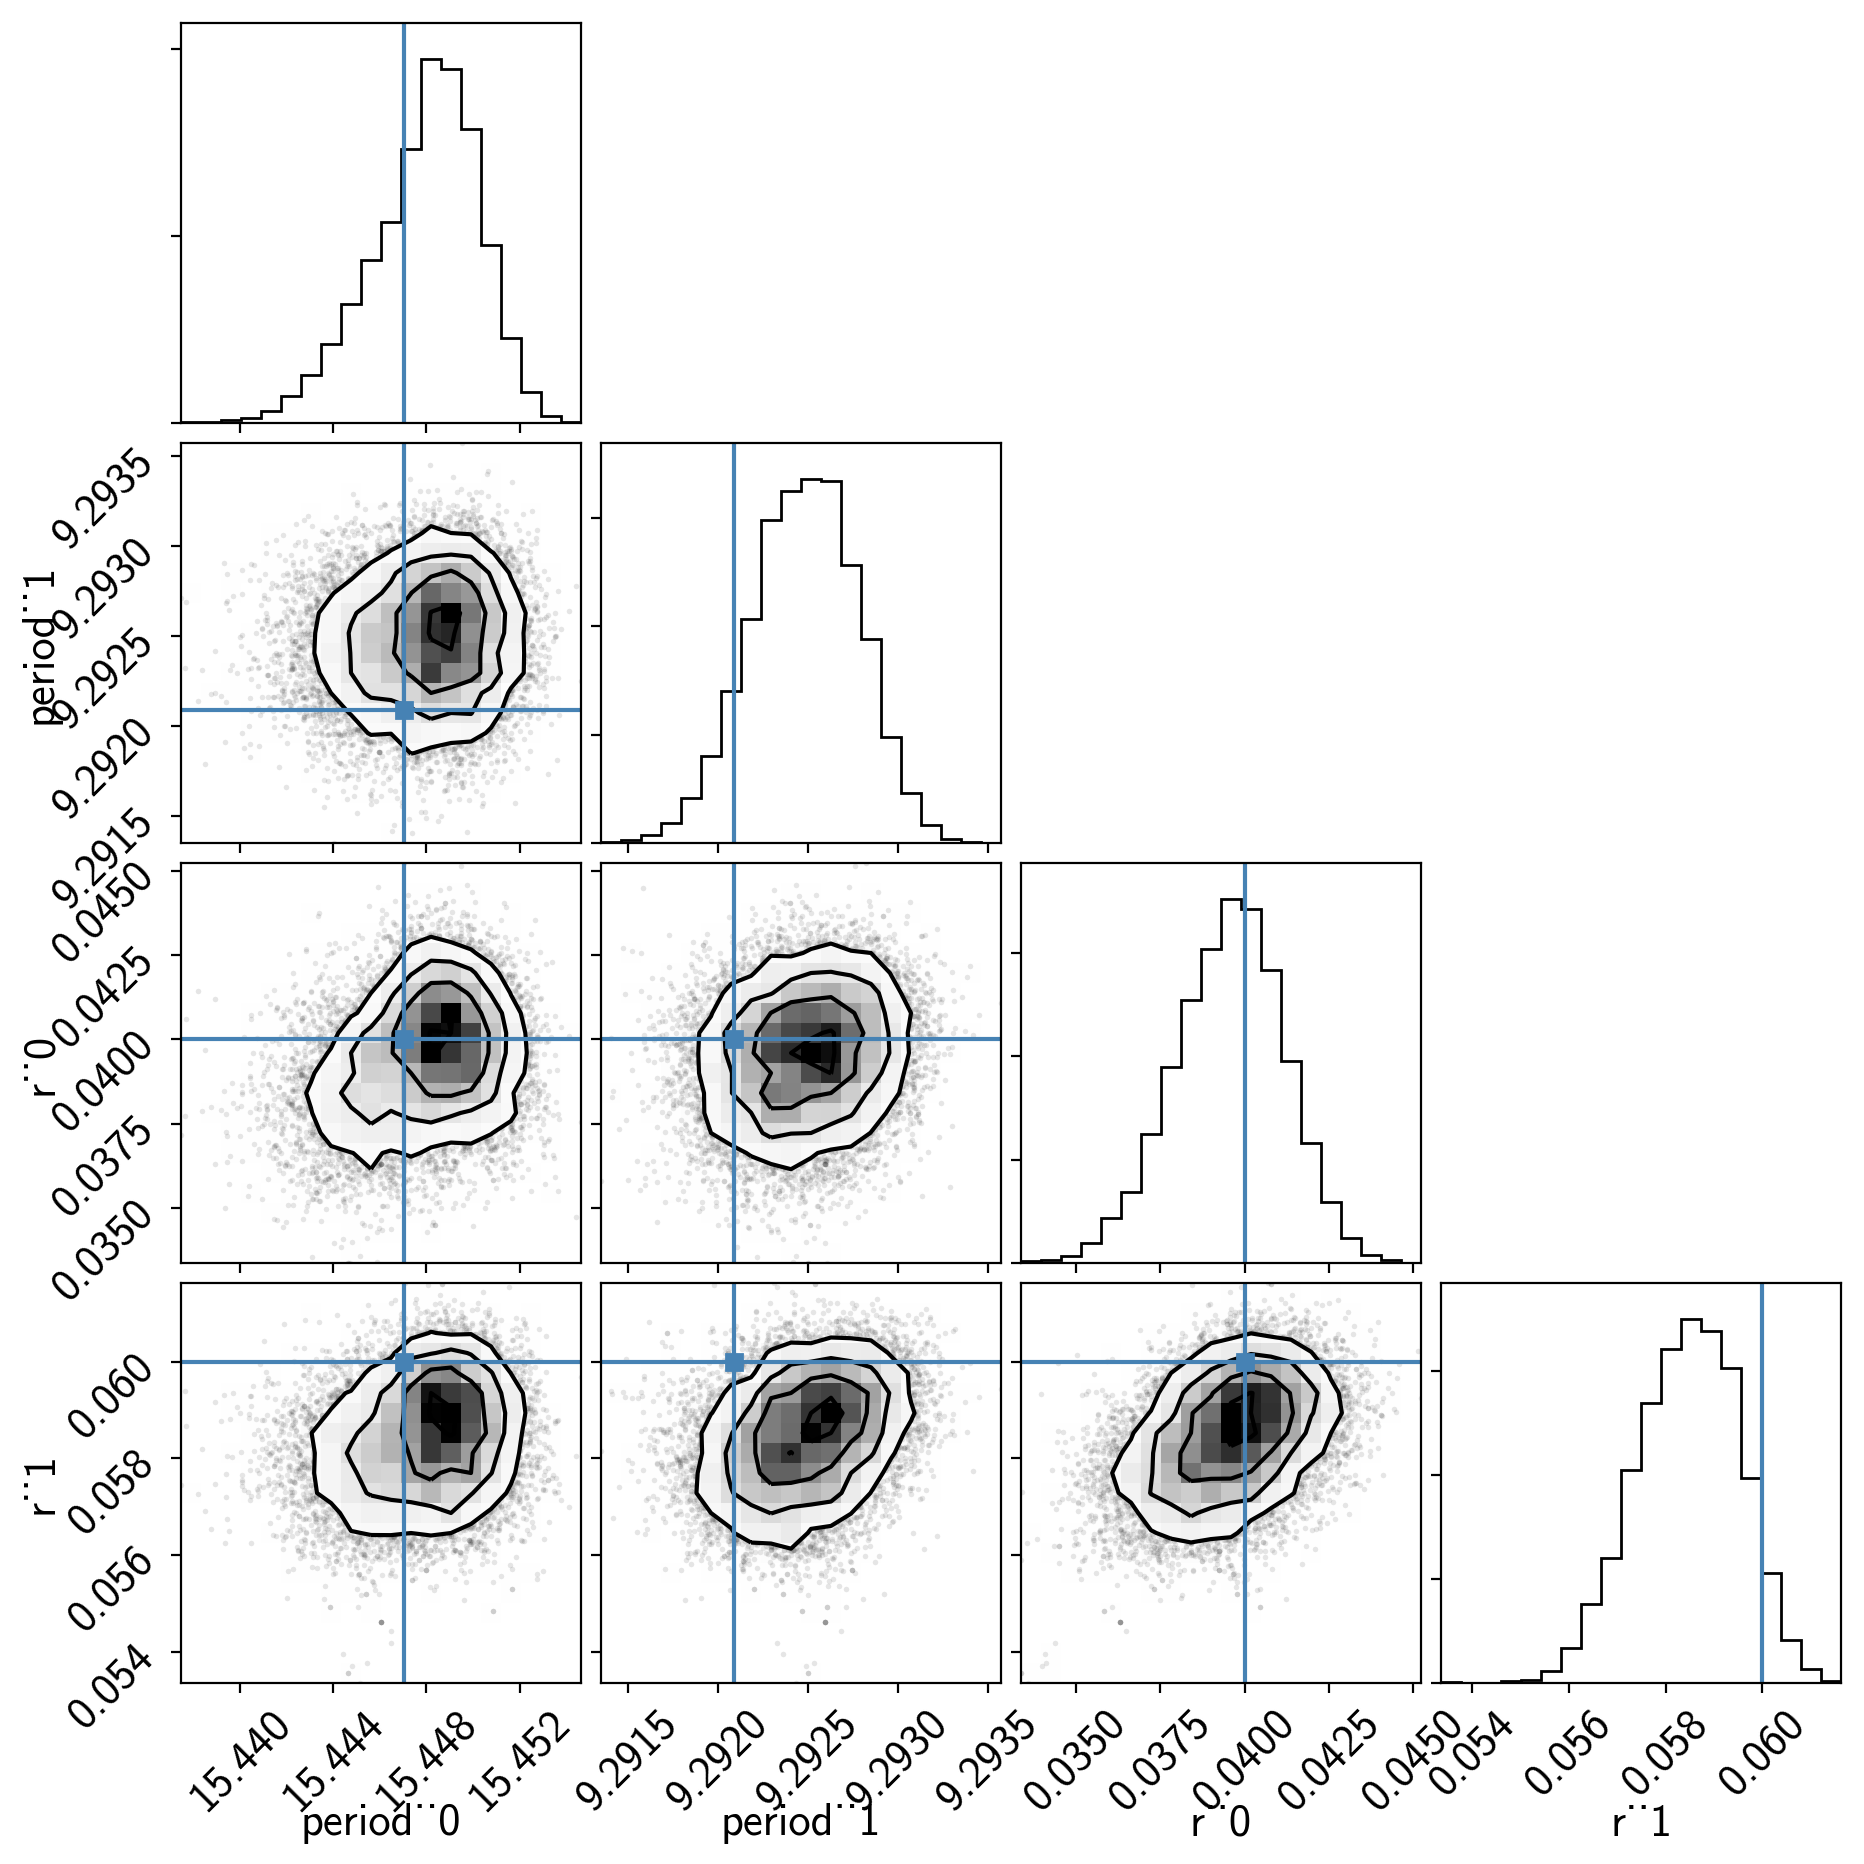

In [9]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["period", "r"])
truth = np.concatenate(xo.eval_in_model([period, r], model.test_point, model=model))
corner.corner(samples, truths=truth);

## Phase plots

Like in the radial velocity tutorial (:ref:`rv`), we can make plots of the model predictions for each planet.

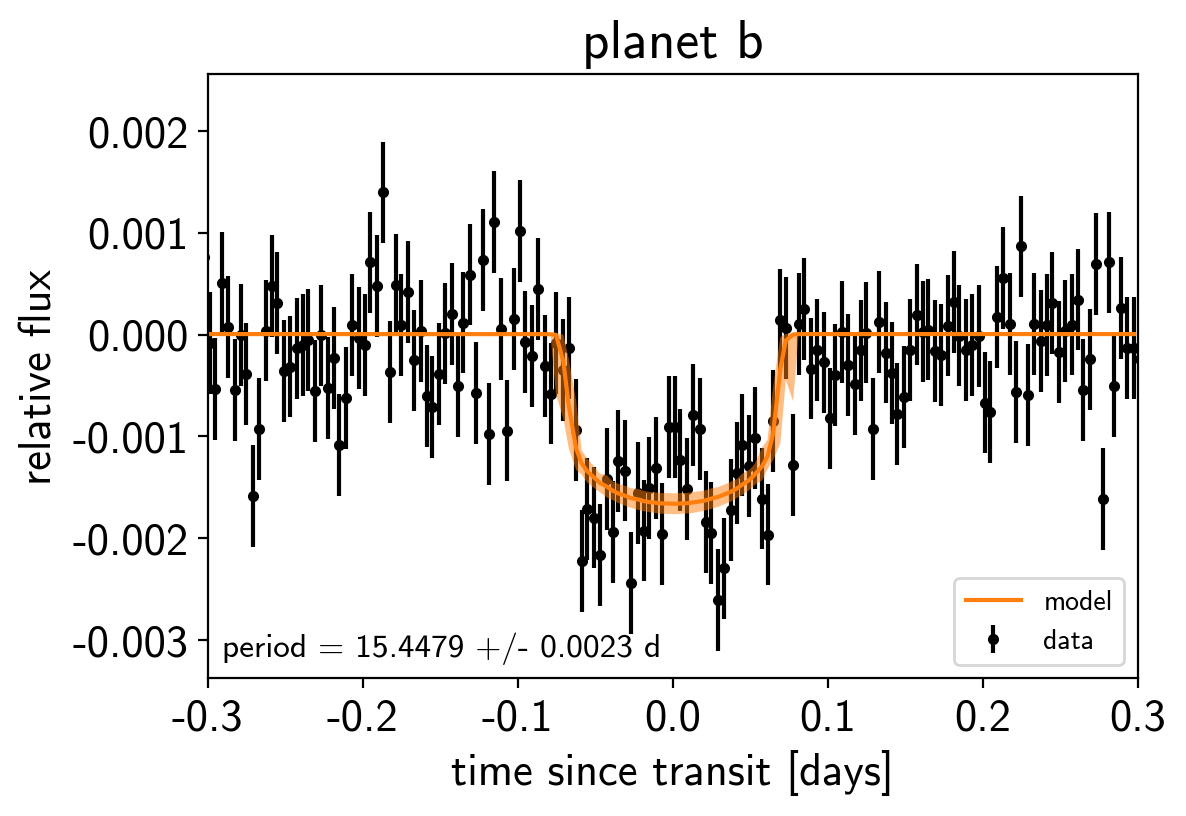

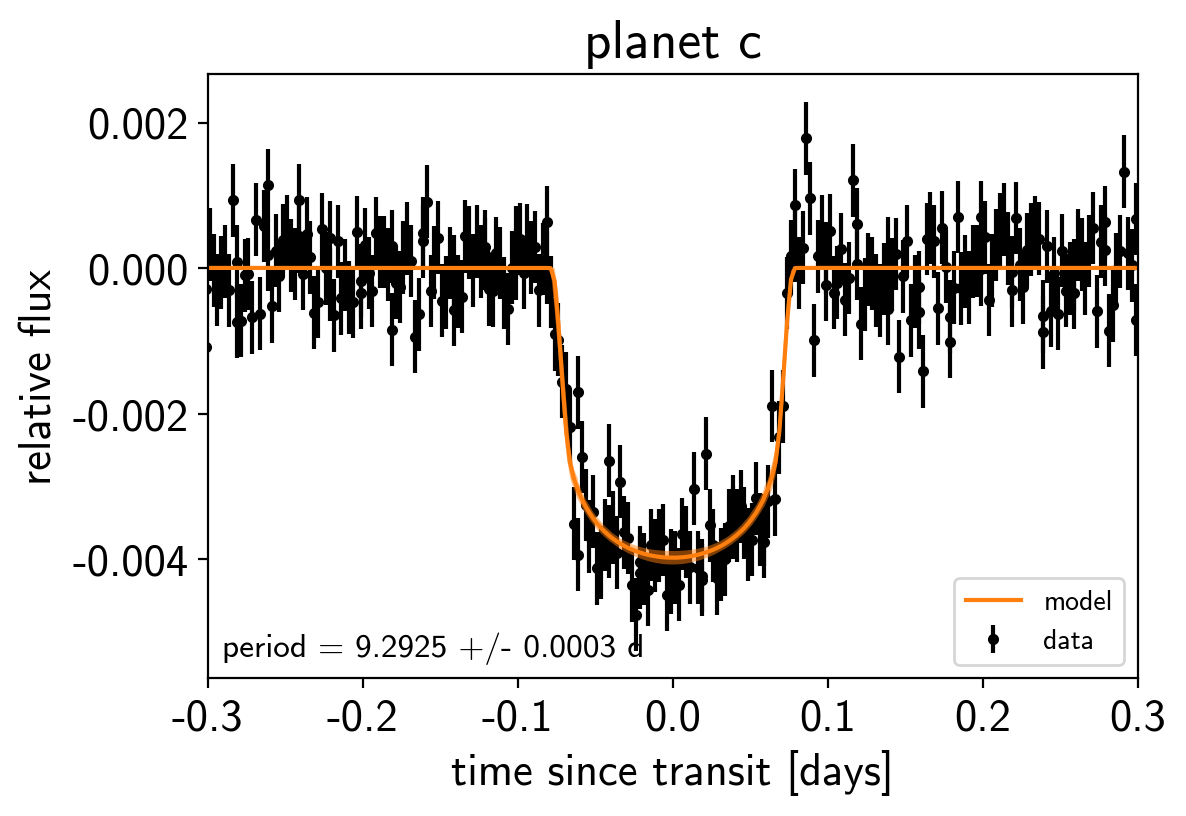

In [10]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (t - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k", label="data",
                 zorder=-1000)
    
    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n] + trace["mean"][:, None]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")
    
    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points", 
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter));
    plt.xlim(-0.3, 0.3)

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.
This is especially important here because we have used quite a few model components that should be cited.

In [11]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [12]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
    title={exoplanet v0.1.3},
   author={Foreman-Mackey, Daniel},
    month={dec},
     year={2018},
      doi={10.5281/zenodo.2536576},
      url={https://doi.org/10.5281/zenodo.2536576}
}

...
